# Possible to-do's and discussion points:
1. [Which annotations to keep?](#different-polymorphism-annotations)
2. [Should we treshold based on the total allele number?](#distribution-across-the-genes)
3. Should we discard pieces of the reference sequence where we have contributions from single sequences and have no mutations present?
4. If yes to 3, what whould be the treshold? Positions occupied by just 1 sequence? Or not more than one gene?

- Add alpha7 dup - IS NOT IN THE DATABASE

# GnomAD analysis
## Library import

In [558]:
from pathlib import Path
import os
import numpy
import pandas

In [559]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqUtils import seq1

In [560]:
from collections import Counter, defaultdict

In [561]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [562]:
import plotly.express as px
import plotly.graph_objects as go

## Importing the files
The raw files come in two sets. One is from GnomAD v3 and the other from GnomAD v2. The second is present as a backup if the mapping to the protein sequence from v3 fails.

In [563]:
_folder_path = Path() / "Raw_data"
_raw_files = [x for x in os.listdir(_folder_path) if os.path.isfile(_folder_path / x)]
_alternative_raw = [file for file in _raw_files if "2.1.1" in file]
_raw_files = list(set(_raw_files) - set(_alternative_raw))
print(*_raw_files, sep="\n")

gnomAD_v3.1.1_ENSG00000102287_2021_08_25_17_51_00_GABRE.csv
gnomAD_v3.1.1_ENSG00000163288_2021_08_25_17_51_16_GABRB1.csv
gnomAD_v3.1.1_ENSG00000138435_2021_08_26_22_09_48_CHRNA1.csv
gnomAD_v3.1.1_ENSG00000094755_2021_08_25_17_53_59_GABRP.csv
gnomAD_v3.1.1_ENSG00000101204_2021_09_06_14_25_11_CHRNA4.csv
gnomAD_v3.1.1_ENSG00000120903_2021_08_26_22_10_13_CHRNA2.csv
gnomAD_v3.1.1_ENSG00000186038_2021_08_25_17_57_43_5HT3E.csv
gnomAD_v3.1.1_ENSG00000151834_2021_08_25_17_49_15_GABRA2.csv
gnomAD_v3.1.1_ENSG00000186090_2021_08_25_17_57_26_5HT3D.csv
gnomAD_v3.1.1_ENSG00000011677_2021_08_25_17_49_37_GABRA3.csv
gnomAD_v3.1.2_ENSG00000135902_2021_10_26_19_04_55_CHRND.csv
gnomAD_v3.1.1_ENSG00000022355_2021_08_25_17_45_26_GABRA1.csv
gnomAD_v3.1.1_ENSG00000109158_2021_08_25_17_49_50_GABRA4.csv
gnomAD_v3.1.1_ENSG00000145888_2021_08_26_22_07_00_GLRA1.csv
gnomAD_v3.1.1_ENSG00000186919_2021_08_26_22_05_56_ZACN.csv
gnomAD_v3.1.2_ENSG00000108556_2021_10_26_19_05_18_CHRNE.csv
gnomAD_v3.1.2_ENSG00000175344_202

We import the files as pandas DataFrame and add a column in which we track the gene of interest.

In [564]:
data = []
for file in _raw_files:
    data.append(pandas.read_csv(_folder_path / file))
    data[-1]["Gene"] = file.split(".")[-2].split("_")[-1]
data_alternative = []
for file in _alternative_raw:
    data_alternative.append(pandas.read_csv(_folder_path / file))
    data_alternative[-1]["Gene"] = file.split(".")[-2].split("_")[-1]

In [565]:
data[0]

,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,Protein Consequence,...,Hemizygote Count Ashkenazi Jewish,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene
0,X,151954644,rs1233803749,G,A,gnomAD Genomes,NaN,PASS,c.*57C>T,NaN,...,0,0,30560,0,0,1,53090,0,1,GABRE
1,X,151954660,NaN,G,T,gnomAD Genomes,NaN,PASS,c.*41C>A,NaN,...,0,0,30510,0,0,1,52982,0,0,GABRE
2,X,151954673,rs1414695956,G,A,gnomAD Genomes,NaN,PASS,c.*28C>T,NaN,...,0,0,30534,0,0,1,53055,0,1,GABRE
3,X,151954675,rs188355390,T,C,gnomAD Genomes,NaN,PASS,c.*26A>G,NaN,...,0,11,29947,0,4,205,52544,1,45,GABRE
4,X,151954685,rs368151888,G,A,gnomAD Genomes,NaN,PASS,c.*16C>T,NaN,...,0,0,30560,0,0,1,53031,0,0,GABRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,X,151974672,rs764077836,G,T,gnomAD Genomes,NaN,PASS,c.-47C>A,NaN,...,0,0,31110,0,0,1,53038,0,0,GABRE
505,X,151974673,rs1370894497,C,T,gnomAD Genomes,NaN,PASS,c.-48G>A,NaN,...,0,1,31107,0,0,0,53047,0,0,GABRE
506,X,151974675,rs1233245266,C,G,gnomAD Genomes,NaN,PASS,c.-50G>C,NaN,...,0,0,31143,0,0,0,53081,0,0,GABRE
507,X,151974676,rs372533373,T,C,gnomAD Genomes,NaN,PASS,c.-51A>G,NaN,...,0,0,31065,0,0,5,52992,0,1,GABRE


Some columns are present only in a subset of files. We will keep them when joining the datasets, and introduce NaN where we have no data.

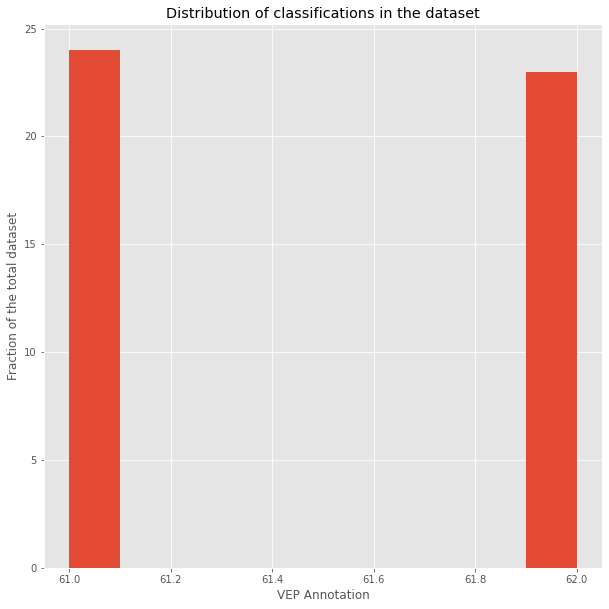

In [566]:
pyplot.hist([len(x.columns) for x in data])
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the total dataset")
pyplot.title("Distribution of classifications in the dataset")
pyplot.show()

## Joining the datasets
We join both the main dataset and the alternative one.

In [567]:
dataset = pandas.concat(data, axis=0, join="outer", ignore_index=True)
dataset_alternative = pandas.concat(data_alternative, axis=0, join="outer", ignore_index=True)

In [568]:
dataset.shape

(28738, 62)

## Exploring the total dataset
### Different polymorphism annotations
For a complete description of the effect annotations see [the ensembl description](https://www.ensembl.org/info/genome/variation/prediction/predicted_data.html).
Only a subset of all the possible annotations is present. Here we focus only on the ones that result in a difference in the protein product. We collect the annotation labels into a list we can invoke later on.

In [569]:
dataset["VEP Annotation"].unique()

array(['3_prime_UTR_variant', 'stop_retained_variant', 'stop_lost',
       'missense_variant', 'synonymous_variant', 'inframe_deletion',
       'stop_gained', 'splice_acceptor_variant', 'splice_region_variant',
       'intron_variant', 'frameshift_variant', 'start_lost',
       '5_prime_UTR_variant', 'splice_donor_variant', 'inframe_insertion',
       'protein_altering_variant', nan], dtype=object)

In [570]:
_VEPs = ["missense_variant",
         "stop_gained",
         "splice_acceptor_variant",
         "splice_donor_variant",
         "frameshift_variant",
         "inframe_deletion",
         "inframe_insertion",
         "start_lost",
         "stop_lost",
         "protein_altering_variant"]

We see that the majority of the mutations of interest get classified into missense mutations (note that the visuals below only look at the labels of interest; though in the first graph the proportion is normalized to the size of the whole dataset, in the pie chart the total is equal to the number of the mutations of interest). As such, it might make sense to discuss if we would be better off disregarding all the other types of mutations just to make our life easier in terms of the analysis. In any event the proportions of different mutation types should probably be shown. 

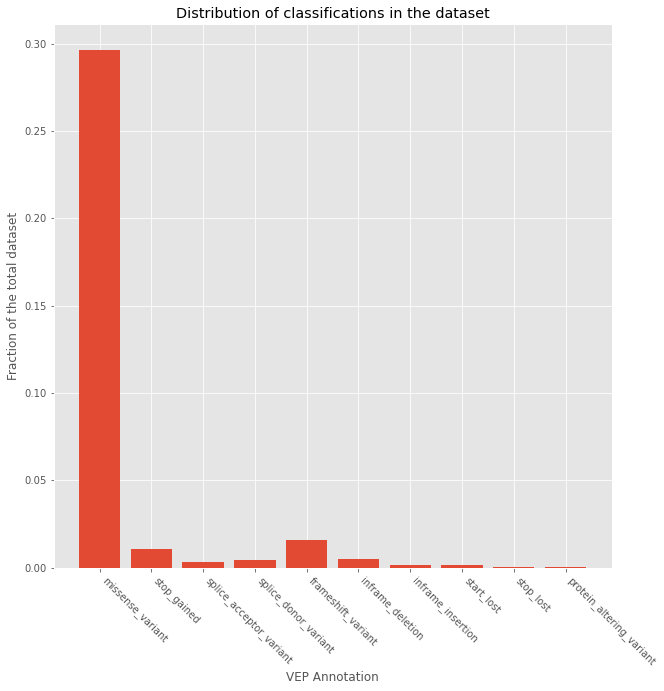

In [571]:
pyplot.bar(_VEPs, [sum(dataset["VEP Annotation"] == x)/dataset.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the total dataset")
pyplot.title("Distribution of classifications in the dataset")
pyplot.show()

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 



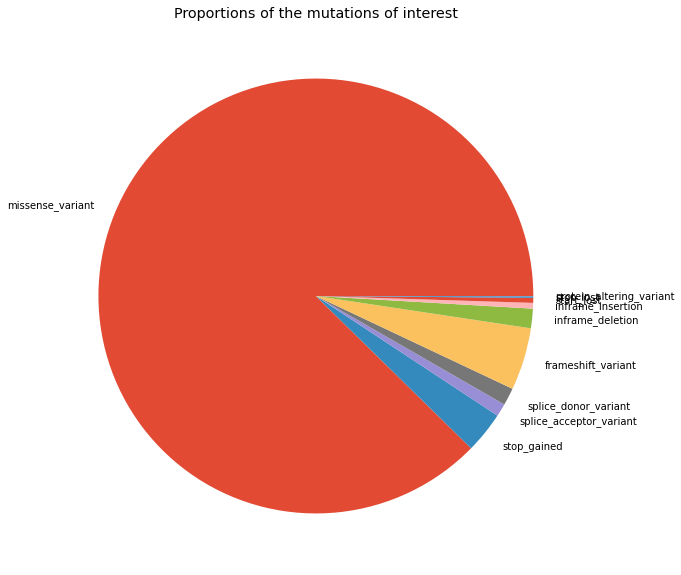

In [572]:
_counts = [sum(dataset["VEP Annotation"] == x)  for x in _VEPs]
_total = sum(_counts)
_counts = [x/_total for x in _counts]
pyplot.pie(_counts, labels=_VEPs)
pyplot.title("Proportions of the mutations of interest")
pyplot.show()

## Filtering

Before filtering anything else, we will discard all the data points where the total allele number deviates too much.

In [573]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

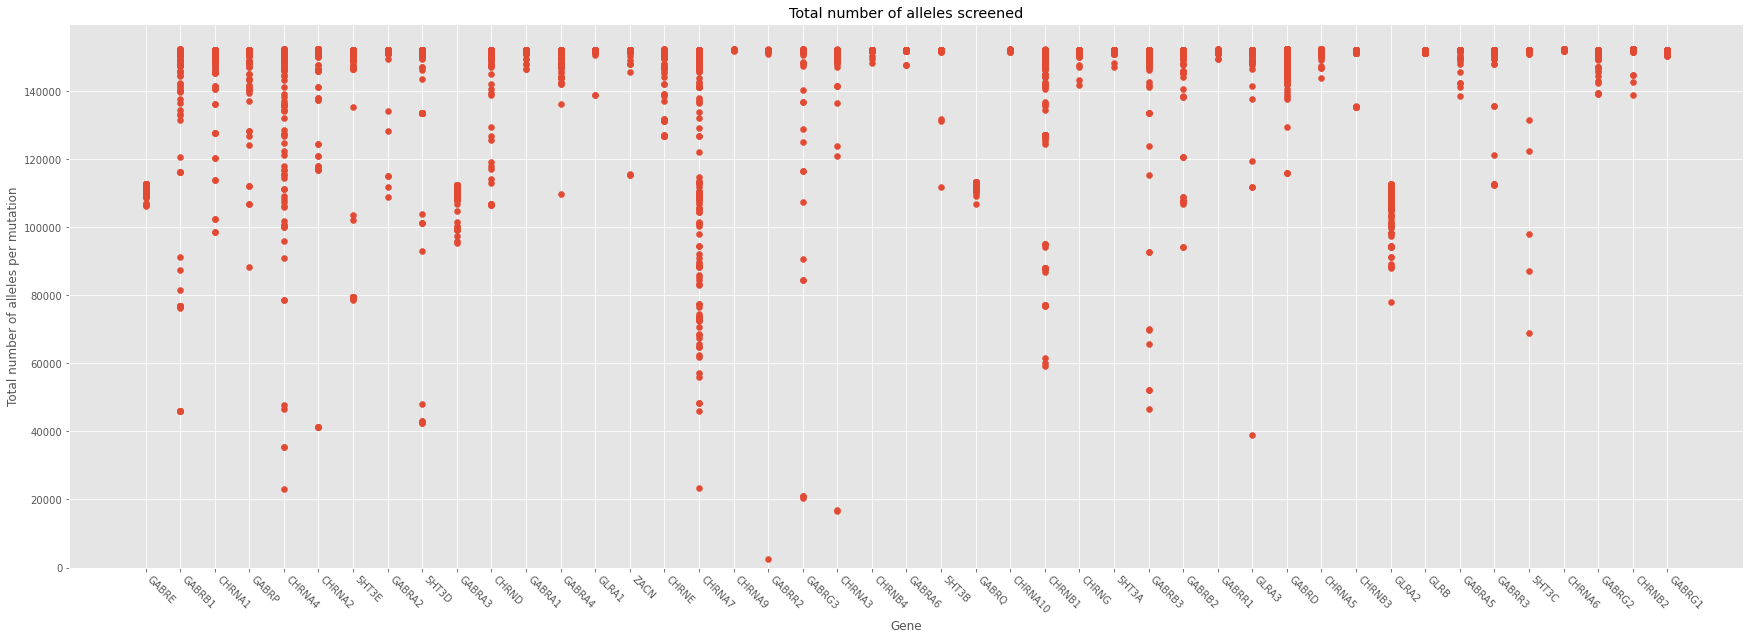

In [574]:
pyplot.scatter(dataset["Gene"], dataset["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Total number of alleles per mutation")
pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
pyplot.show()

In [575]:
_mean_af = dataset["Allele Number"].mean()
_std_af = dataset["Allele Number"].std()
print(f"Mean: {_mean_af}\nS. dev.: {_std_af}")

Mean: 148916.9469892099
S. dev.: 11639.162625345803


In [576]:
dataset = dataset[dataset.apply(lambda x: abs(x["Allele Number"] - _mean_af) < 3*_std_af, axis=1)]

Let's check again how the distribution looks like.

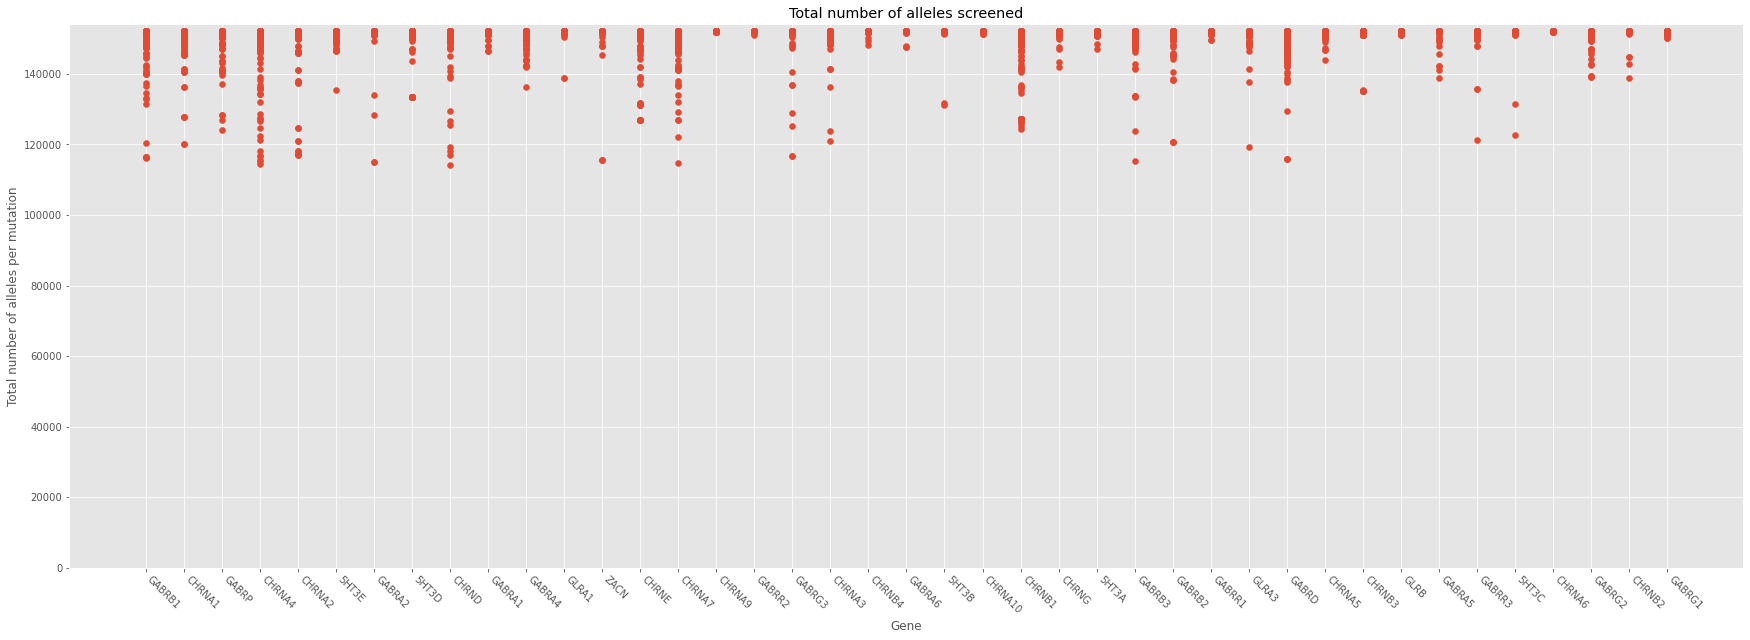

In [577]:
pyplot.scatter(dataset["Gene"], dataset["Allele Number"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Total number of alleles per mutation")
pyplot.title("Total number of alleles screened")
ax = pyplot.gca()
ax.set_ylim([0, None])
pyplot.show()

We filter only for the GnomAD data.

In [578]:
dataset = dataset[dataset["Source"] == "gnomAD Genomes"]
dataset.reset_index(inplace=True)

In [579]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

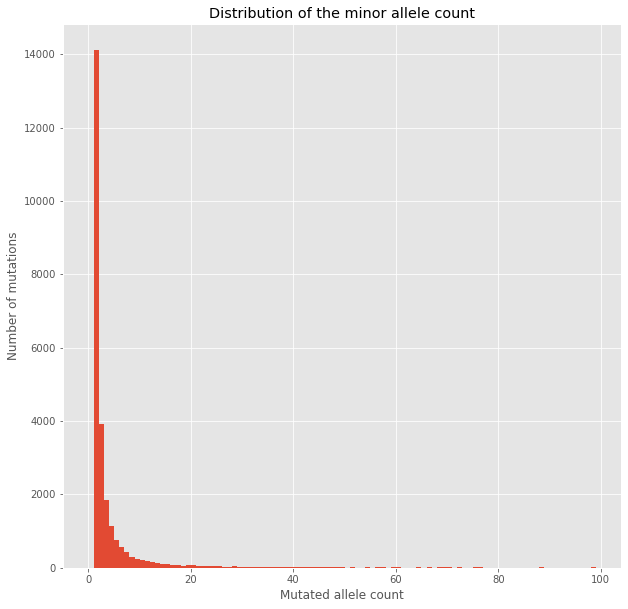

In [580]:
pyplot.hist(dataset["Allele Count"], bins=[x for x in range(0, 100)])
pyplot.xlabel("Mutated allele count")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele count")
pyplot.show()

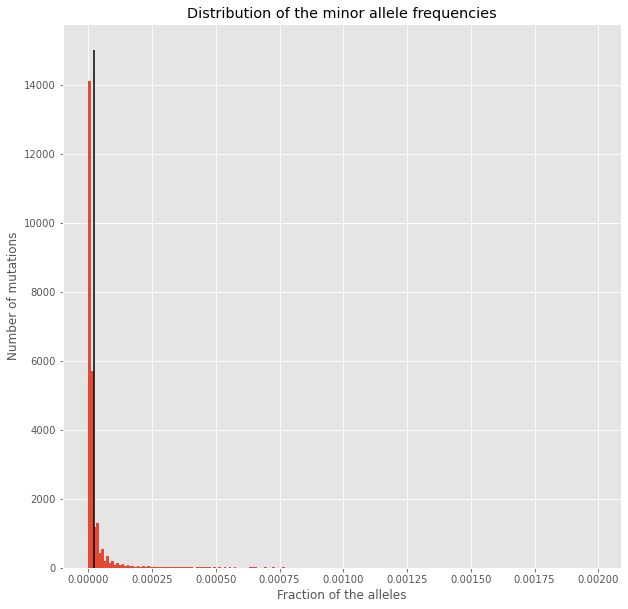

In [581]:
pyplot.hist(dataset["Allele Count"]/dataset["Allele Number"], bins=[x*0.00001 for x in range(0, 200)])
pyplot.vlines([0.00002], ymin=0, ymax=15000, colors="black")
pyplot.xlabel("Fraction of the alleles")
pyplot.ylabel("Number of mutations")
pyplot.title("Distribution of the minor allele frequencies")
pyplot.show()

For now we filter by including only variants present in at least 0.002 % of the population. The treshold is discussable, as the current one was chosen mainly just to perform some level of selection while also retaining a meaningful amount of data. Based on the majority of the sample sizes (see also below for a graphical depiction) the cutoff should in the majority of cases be in the range of 10 detected alleles.

We also retain just the columns of interest. Let's see the distribution of the annotations now.

In [582]:
subdata = dataset[dataset["Allele Count"]/dataset["Allele Number"] > 0.00002]
subdata = subdata[subdata["VEP Annotation"].isin(_VEPs)]
subdata

,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,HGVS Consequence,...,Allele Count African/African-American,Allele Number African/African-American,Homozygote Count African/African-American,Hemizygote Count African/African-American,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript
26,535,4,47031703.0,rs977009229,A,G,gnomAD Genomes,NaN,PASS,p.Met18Val,...,0.0,41396.0,0.0,0.0,1.0,68016.0,0.0,0.0,GABRB1,NaN
78,595,4,47031919.0,rs148675961,A,G,gnomAD Genomes,NaN,PASS,p.Asn29Ser,...,9.0,41406.0,0.0,0.0,1.0,68002.0,0.0,0.0,GABRB1,NaN
87,604,4,47031969.0,rs775250287,A,G,gnomAD Genomes,NaN,PASS,p.Lys46Glu,...,1.0,41348.0,0.0,0.0,3.0,68006.0,0.0,0.0,GABRB1,NaN
91,608,4,47031996.0,rs142160221,G,A,gnomAD Genomes,NaN,PASS,p.Asp55Asn,...,2.0,40822.0,0.0,0.0,2.0,67900.0,0.0,0.0,GABRB1,NaN
194,724,4,47161424.0,rs200428754,G,A,gnomAD Genomes,NaN,PASS,p.Arg139Gln,...,1.0,41386.0,0.0,0.0,3.0,67964.0,0.0,0.0,GABRB1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26804,28691,4,46123822.0,rs564894450,T,C,gnomAD Genomes,NaN,PASS,p.His31Arg,...,1.0,41424.0,0.0,0.0,0.0,68004.0,0.0,0.0,GABRG1,NaN
26812,28699,4,46123859.0,rs770228084,T,C,gnomAD Genomes,NaN,PASS,p.Arg19Gly,...,0.0,41454.0,0.0,0.0,5.0,68012.0,0.0,0.0,GABRG1,NaN
26813,28700,4,46123866.0,rs148202098,A,T,gnomAD Genomes,NaN,PASS,p.Ser16Arg,...,6.0,41398.0,0.0,0.0,18.0,68006.0,0.0,0.0,GABRG1,NaN
26818,28705,4,46123877.0,rs140068403,G,T,gnomAD Genomes,NaN,PASS,p.Leu13Ile,...,4.0,41424.0,0.0,0.0,29.0,68012.0,0.0,0.0,GABRG1,NaN


If we look at the distribution of mutations across the annotation labels as before, we see that the distribution has become even more skewed towards the missense variants.

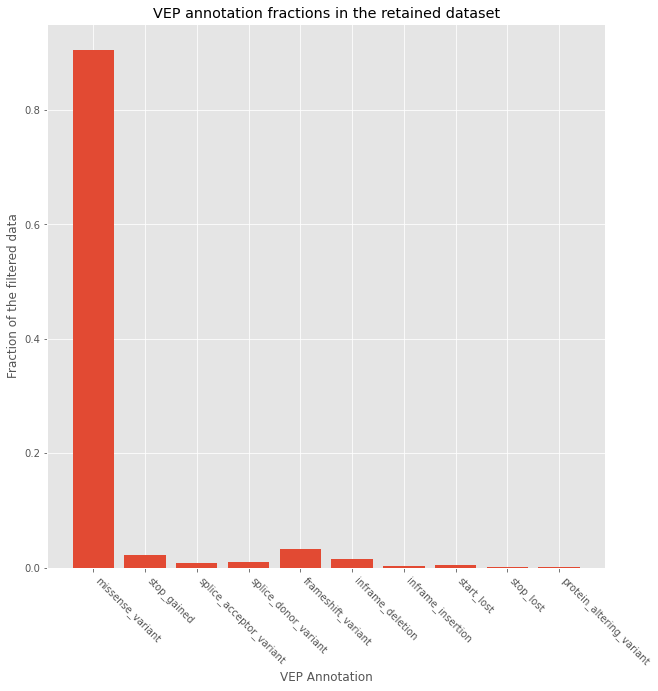

In [583]:
pyplot.bar(_VEPs, [sum(subdata["VEP Annotation"] == x)/subdata.shape[0]  for x in _VEPs])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("VEP Annotation")
pyplot.ylabel("Fraction of the filtered data")
pyplot.title("VEP annotation fractions in the retained dataset")
pyplot.show()

## Distribution across the genes
First we just look at the number of different polymorphisms detected for each gene.

In [584]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [585]:
_genes = subdata["Gene"].unique()
_values = pandas.DataFrame({"Gene": _genes, "Value": [sum(subdata["Gene"] == x)/subdata.shape[0]  for x in _genes]})
_values.sort_values(by="Value", ascending=False, inplace=True, ignore_index=True)

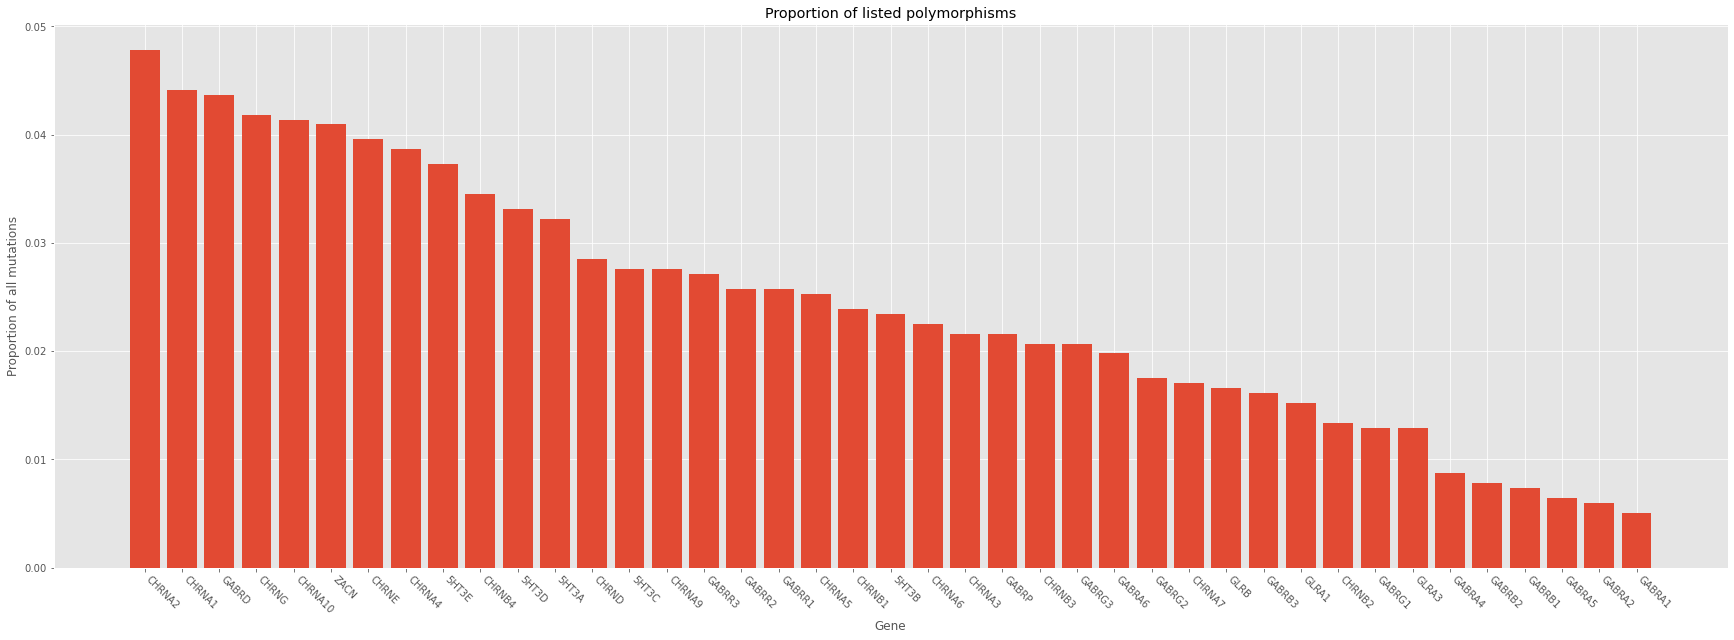

In [586]:
pyplot.bar(_values["Gene"], _values["Value"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Proportion of all mutations")
pyplot.title("Proportion of listed polymorphisms")
pyplot.show()

We might want to discard some samples where total allele number is lower than some set treshold, as these might become the possible outliers in later statistics.

Next we look at the allele counts across all the mutations for single genes to get a feeling for which genes drive the statistical power in our sample. 

In [587]:
_values["Allele Count"] = [sum(subdata["Allele Count"][subdata["Gene"] == x]) for x in _values["Gene"]]
_values.sort_values(by="Allele Count", ascending=False, inplace=True, ignore_index=True)

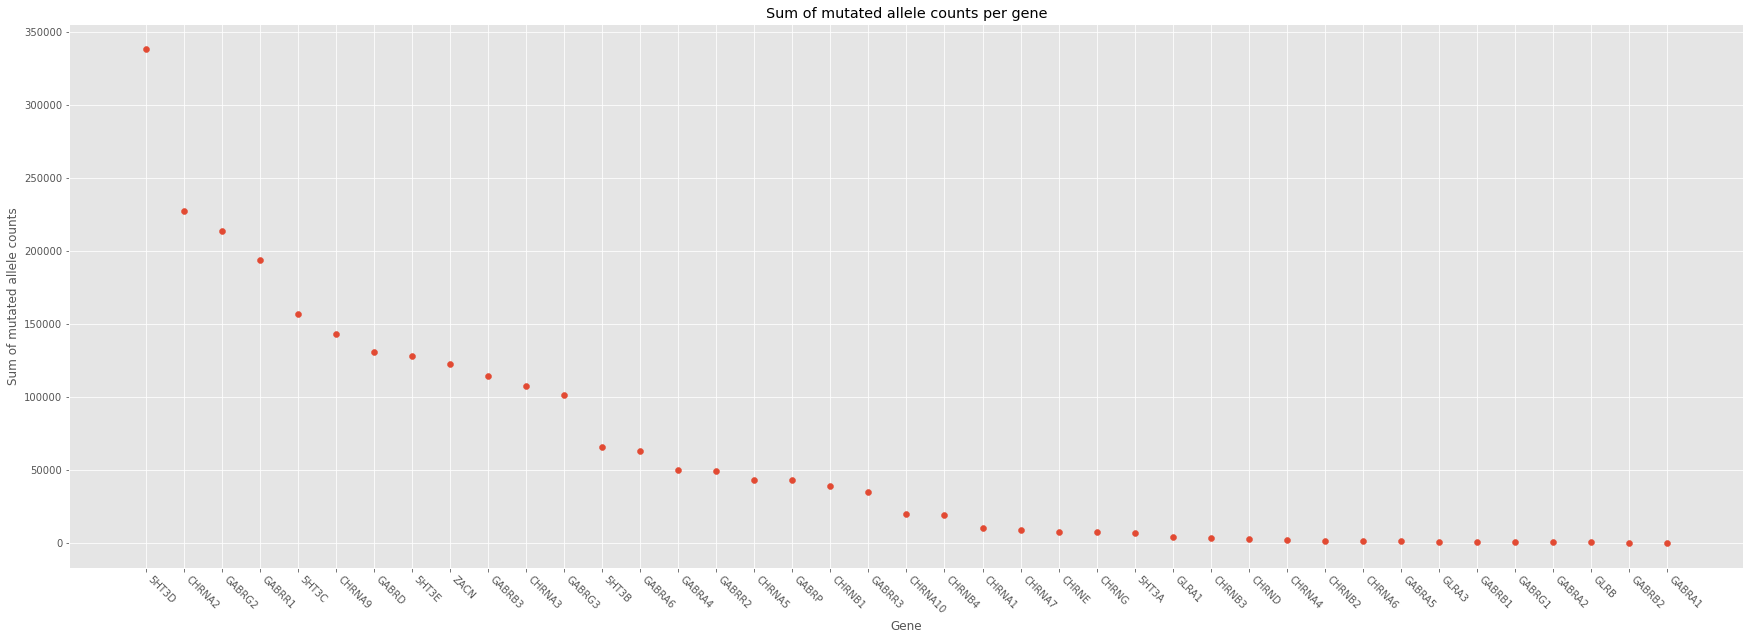

In [588]:
pyplot.scatter(_values["Gene"], _values["Allele Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Sum of mutated allele counts")
pyplot.title("Sum of mutated allele counts per gene")
pyplot.show()

## Extracting the AA number from missense variants
We extracted the numbering of amino acid from `Protein Sequence` column. Then we used UniProt for determining the lengths of all proteins and normalized the position of amino acids to the full protein lengths. For a more in-depth analysis we would need an alignment.

We then look at the relative positions of the mutations for each gene separately by plotting the histograms one by one.

In [589]:
missense = subdata[subdata["VEP Annotation"] == "missense_variant"]
missense["AA Number"] = missense["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32")
missense.reset_index(inplace=True)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [590]:
missense["AA Relative"] = 0
# Lengths are taken from UniProt
lengths = {
    "GABRA3": 492,
    "GABRA1": 456,
    "CHRNA3": 505,
    "GABRP": 440,
    "CHRNA4": 627,
    "GLRA2": 452,
    "GABRE": 506,
    "GABRA4": 554, 
    "GLRB": 497,
    "GABRR2": 465,
    "GABRG2": 467,
    "CHRNA2": 529,
    "CHRNA1": 482,
    "GLRA3": 464,
    "GABRA6": 453,
    "GABRB2": 512,
    "GLRA1": 457,
    "GABRR1": 479,
    "CHRNA6": 494,
    "5HT3B": 441,
    "GABRA2": 451,
    "GABRG1": 465,
    "GABRB1": 474,
    "GABRB3": 473,
    "5HT3A": 478,
    "CHRNA5": 468,
    "5HT3C": 447,
    "GABRG3": 467,
    "GABRR3": 467,
    "5HT3E": 456,
    "5HT3D": 454,
    "GABRA5": 462,
    "ZACN": 412,
    "GABRD": 452,
    "GABRQ": 632,
    "CHRNE": 493,
    "CHRNB4": 498,
    "CHRNA10": 450,
    "CHRND": 517,
    "CHRNB3": 458,
    "CHRNB2": 502,
    "CHRNB1": 501,
    "CHRNA9": 479,
    "CHRNA7": 502,
    "CHRNG": 517,
}
for gene in missense["Gene"].unique():
    missense["AA Relative"][missense["Gene"] == gene] = missense["AA Number"][missense["Gene"] == gene] / lengths[gene]

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packa

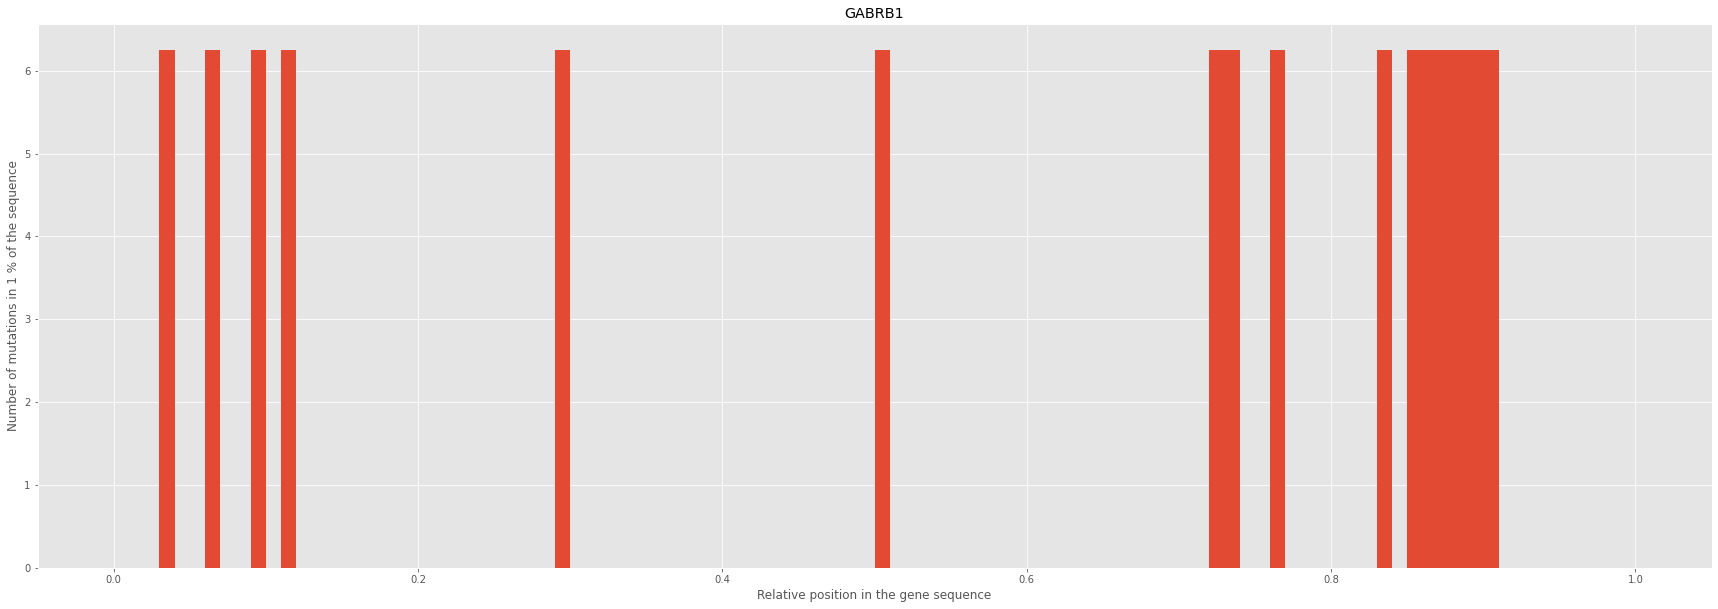

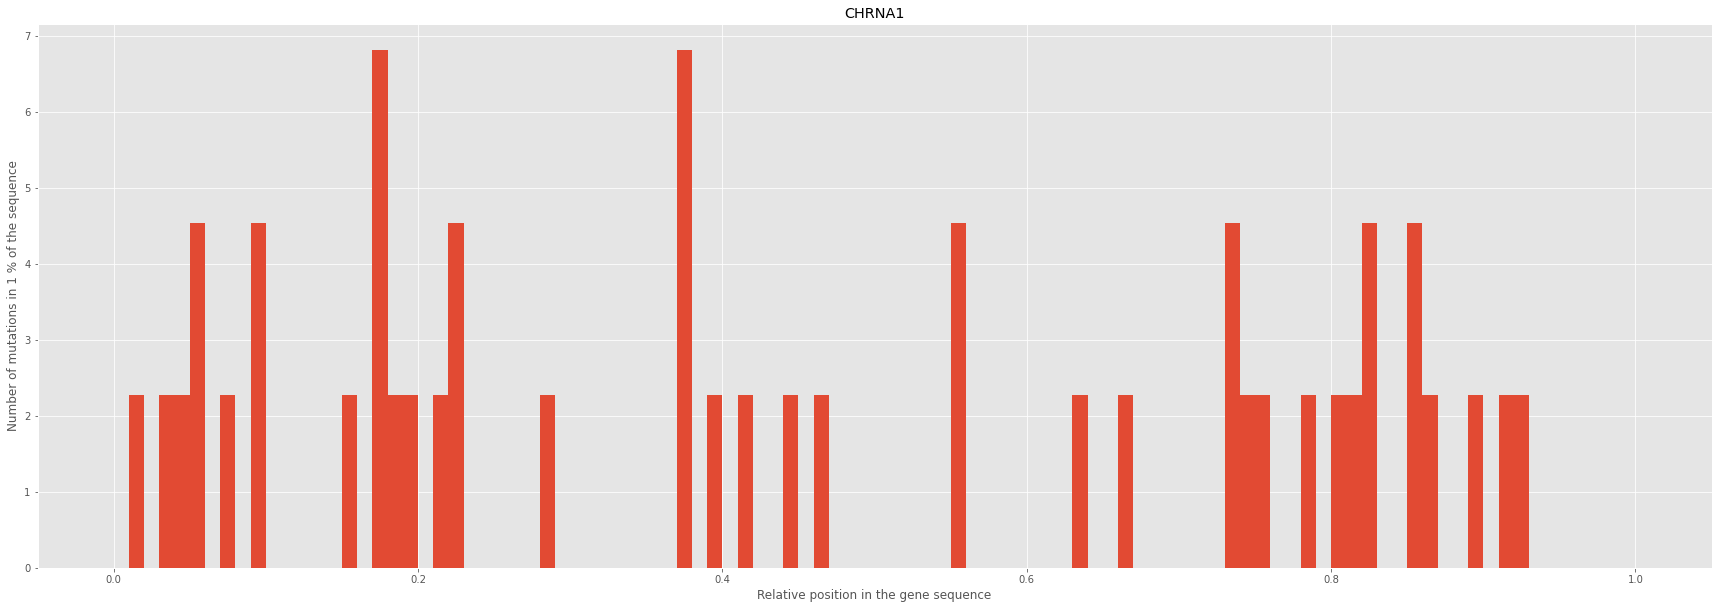

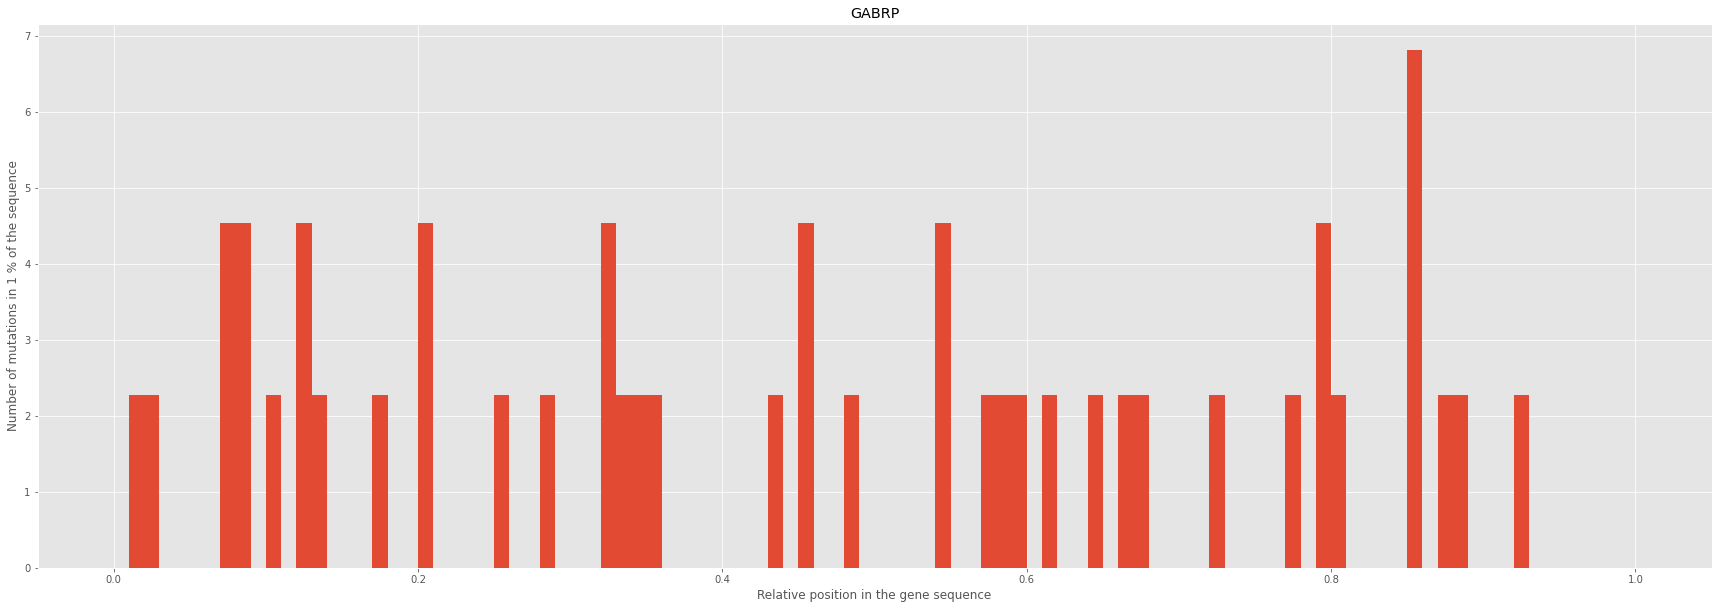

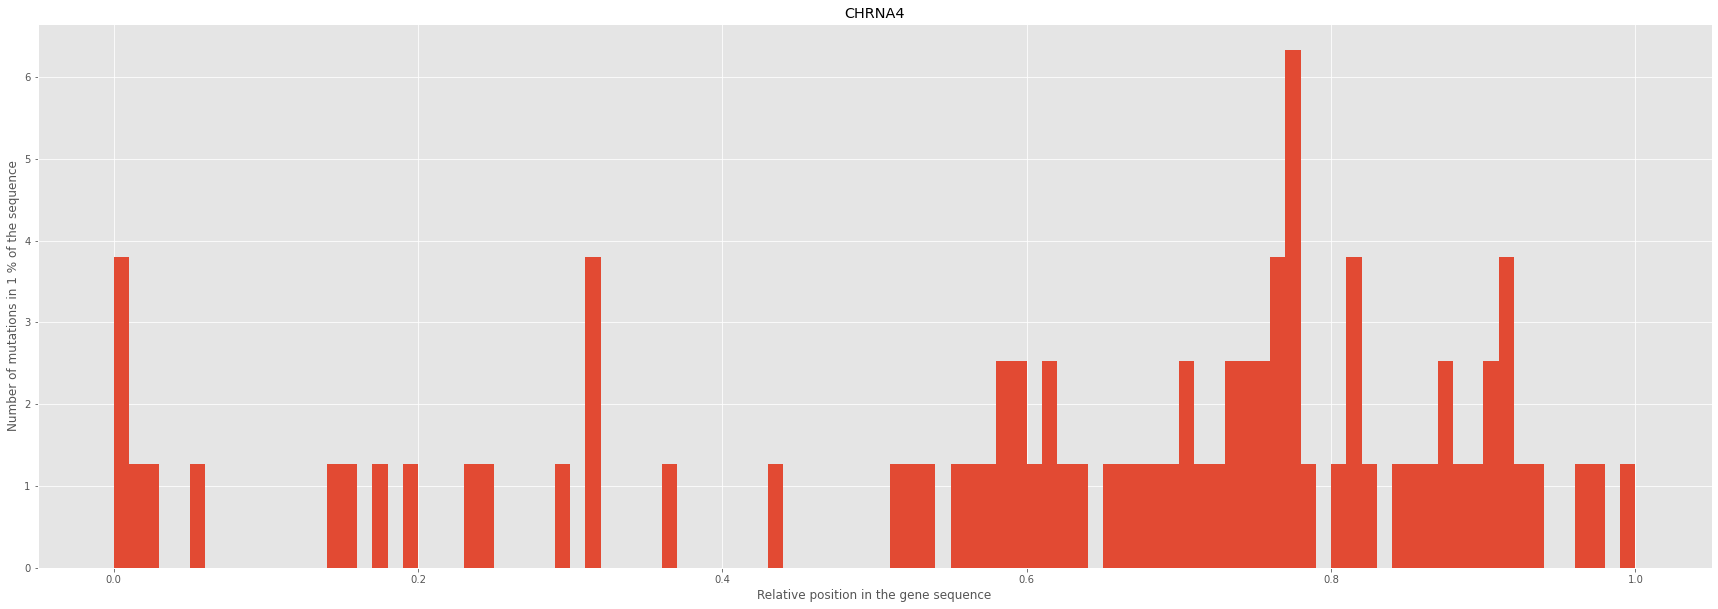

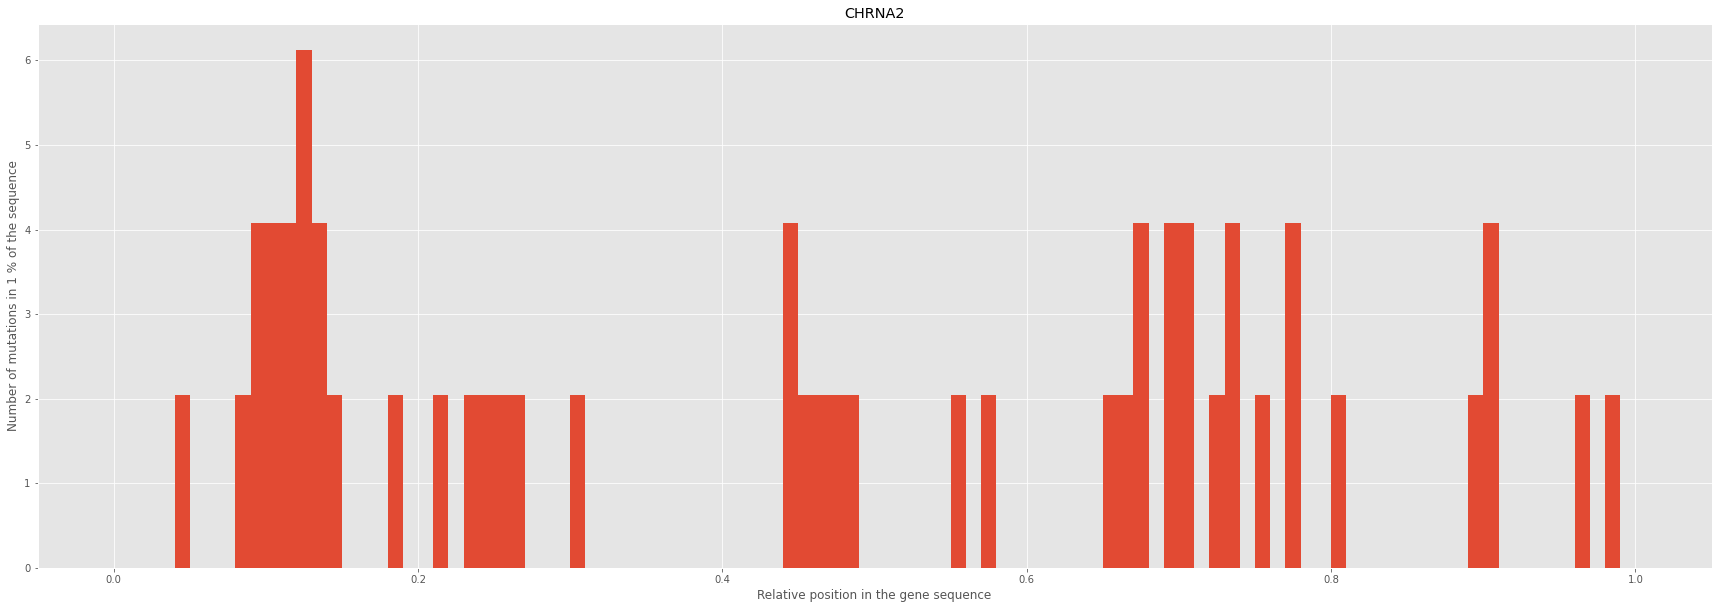

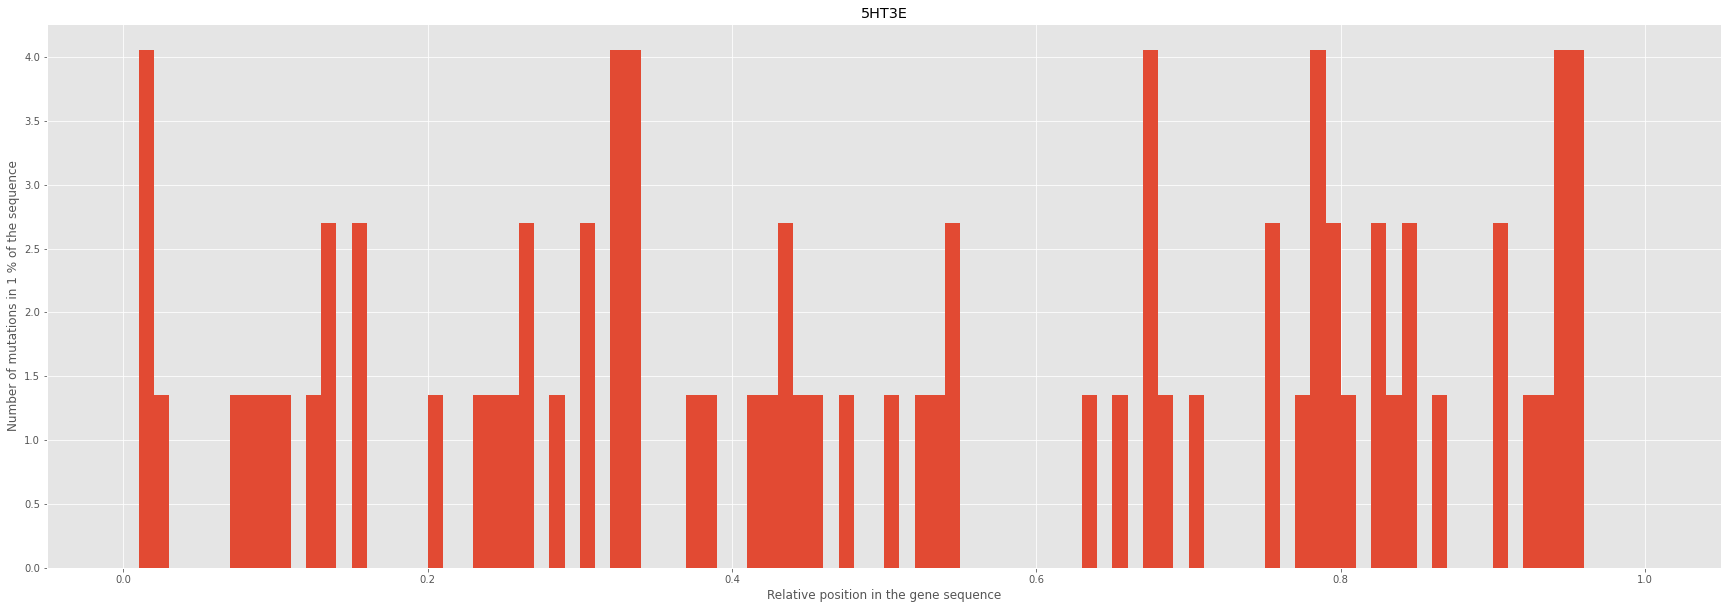

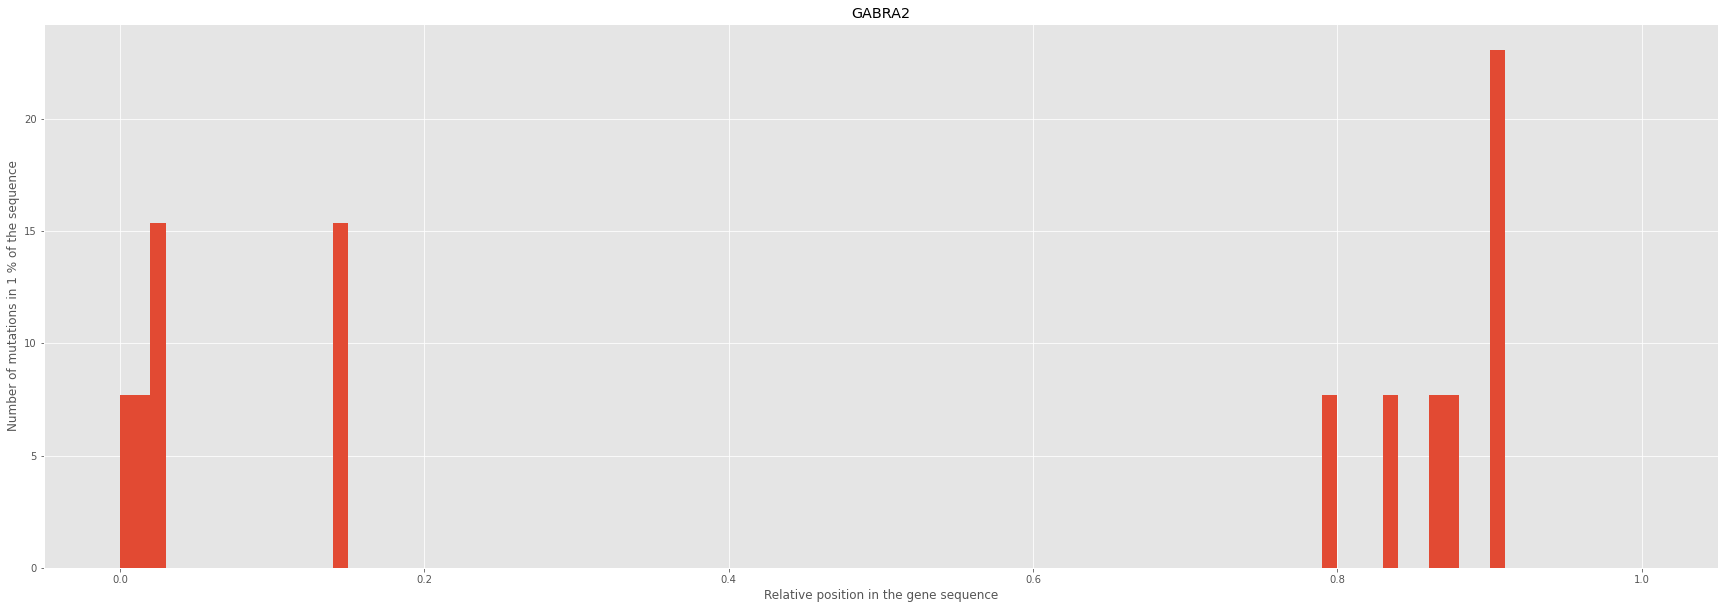

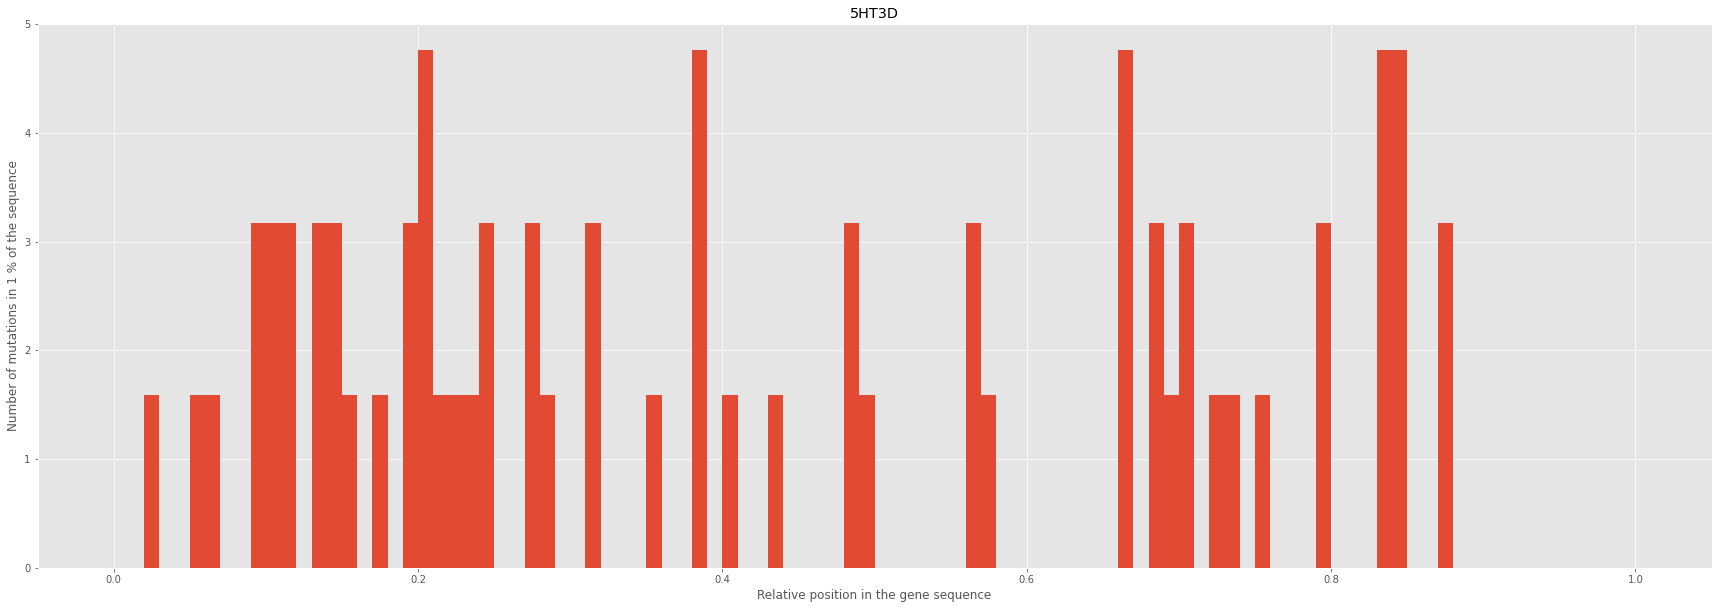

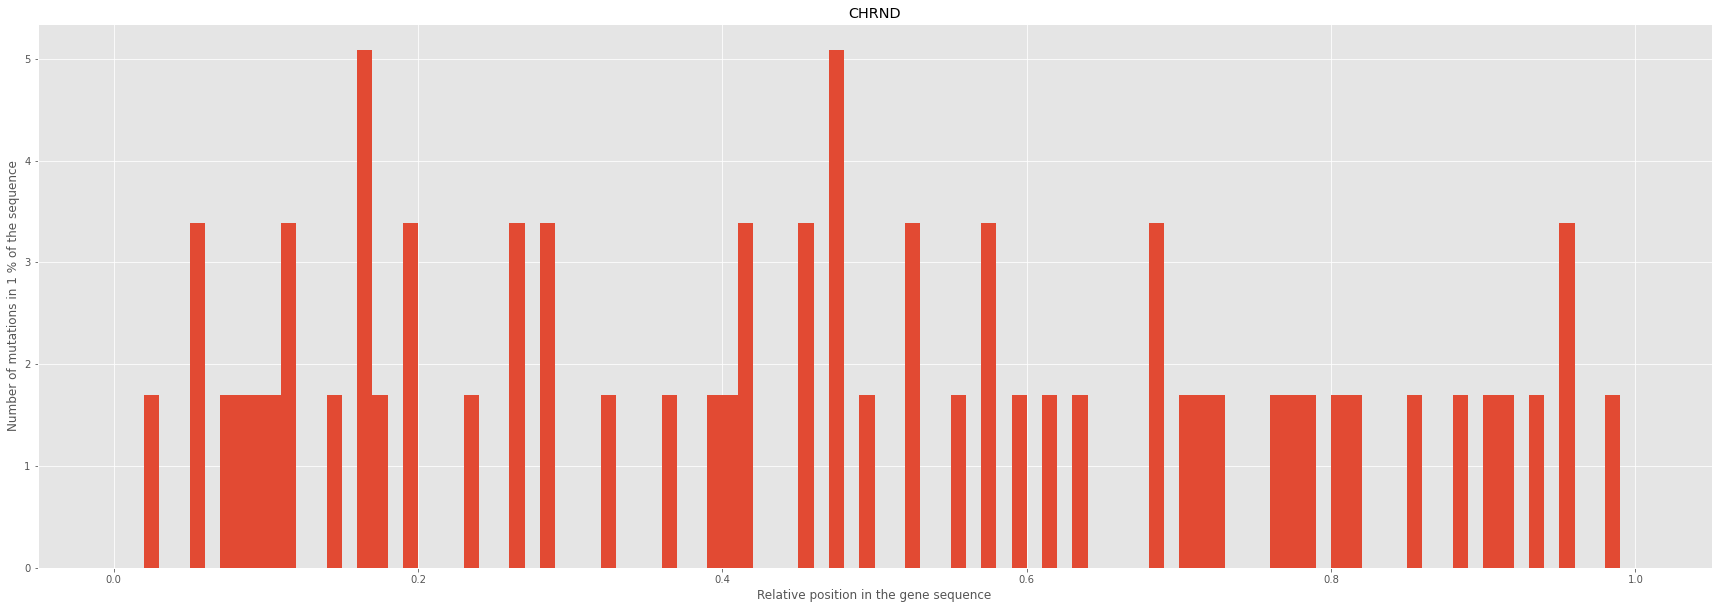

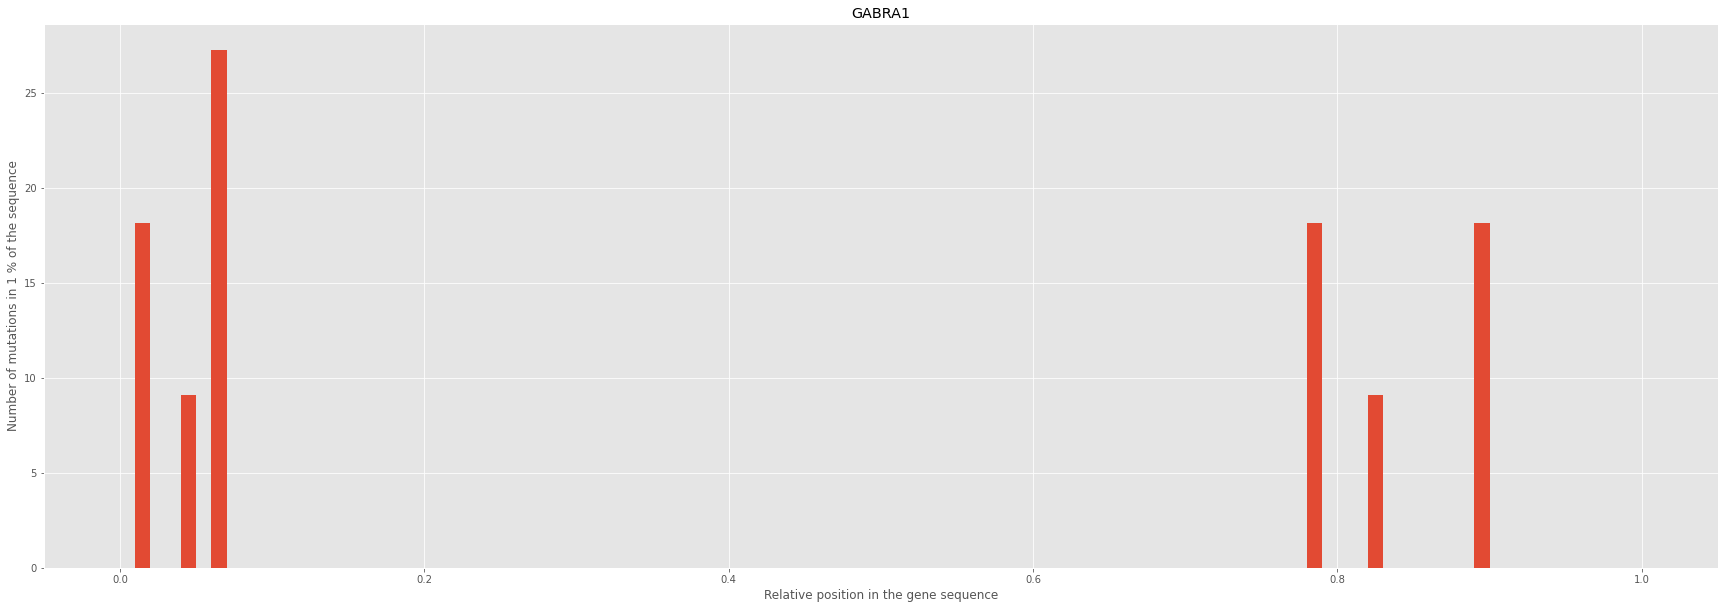

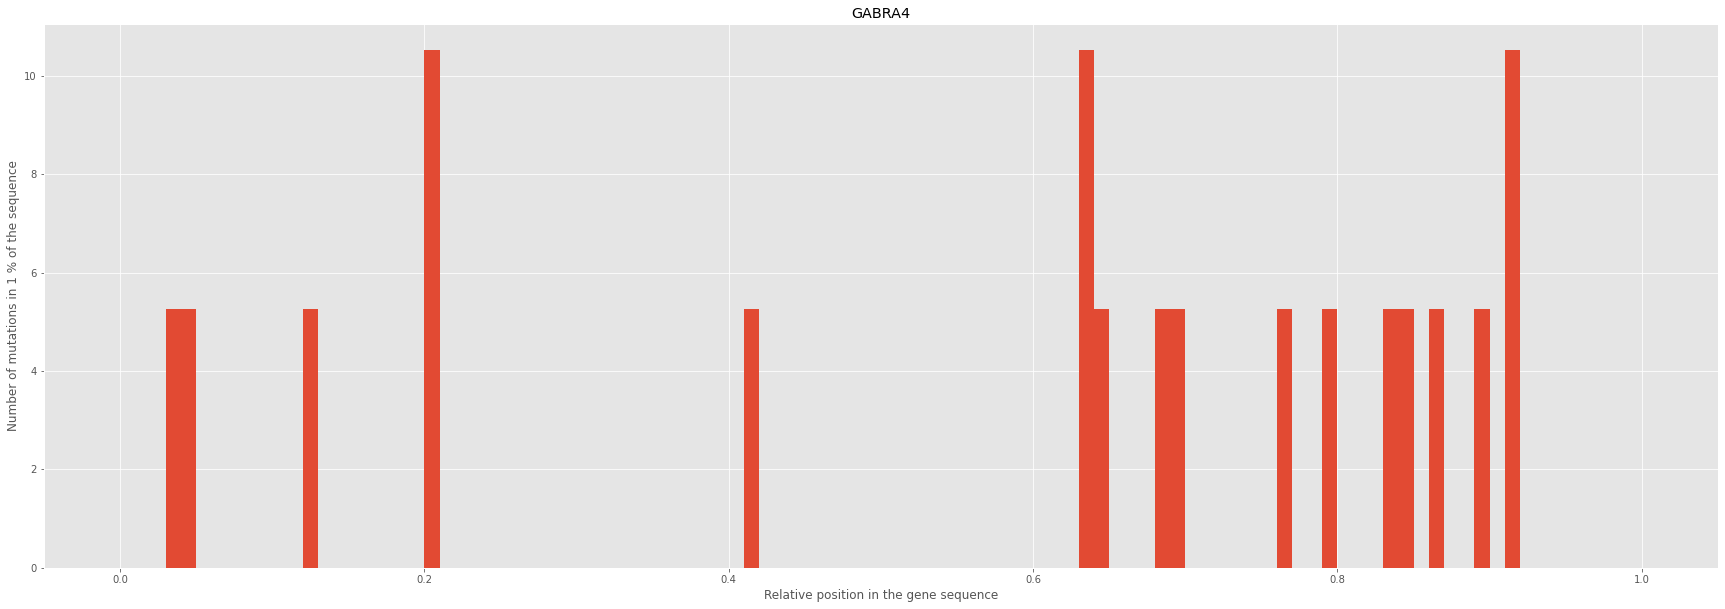

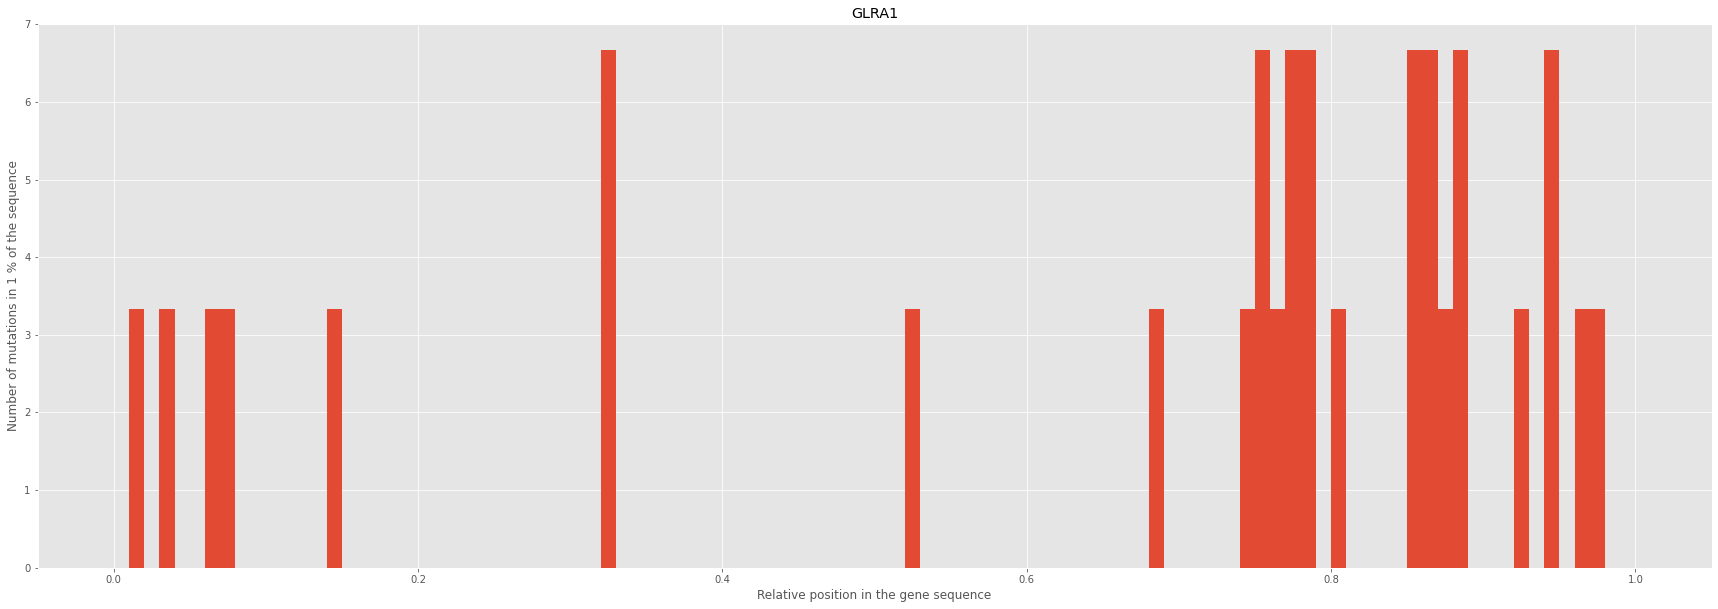

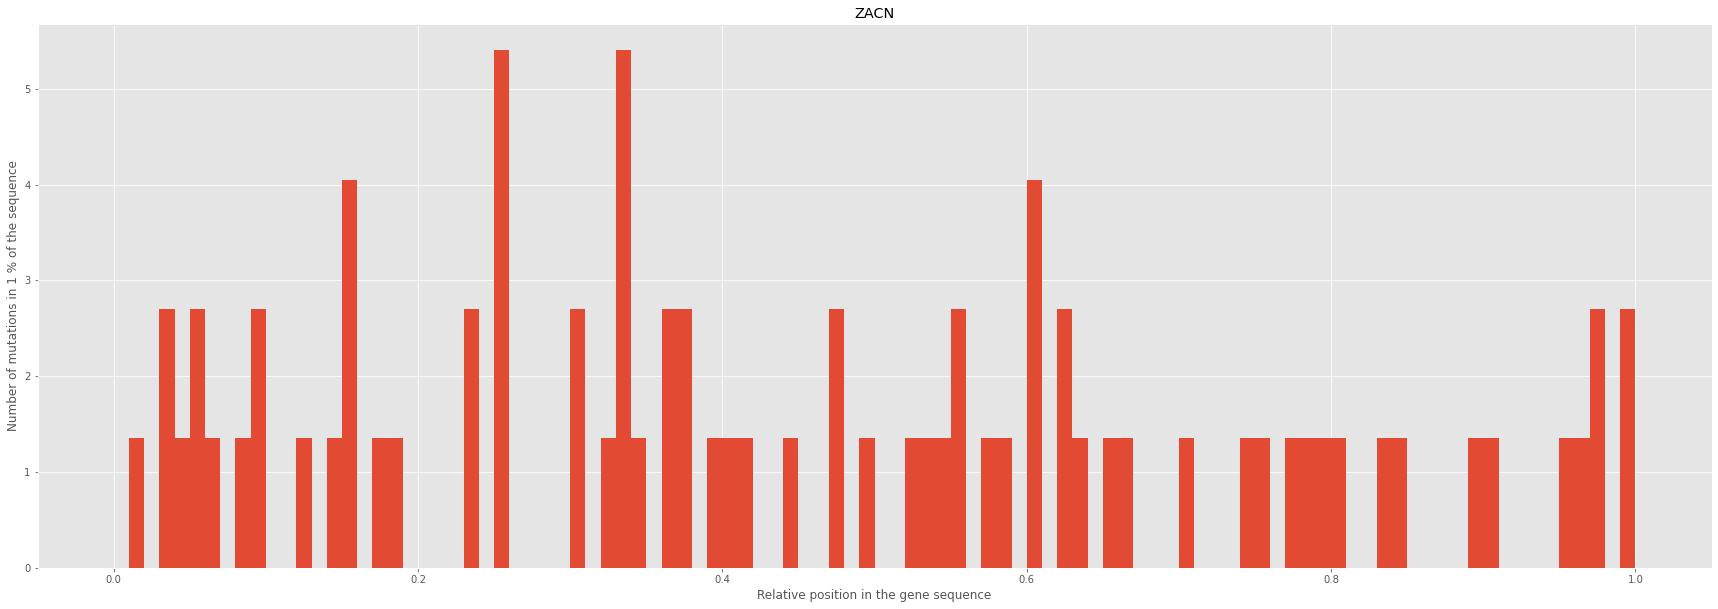

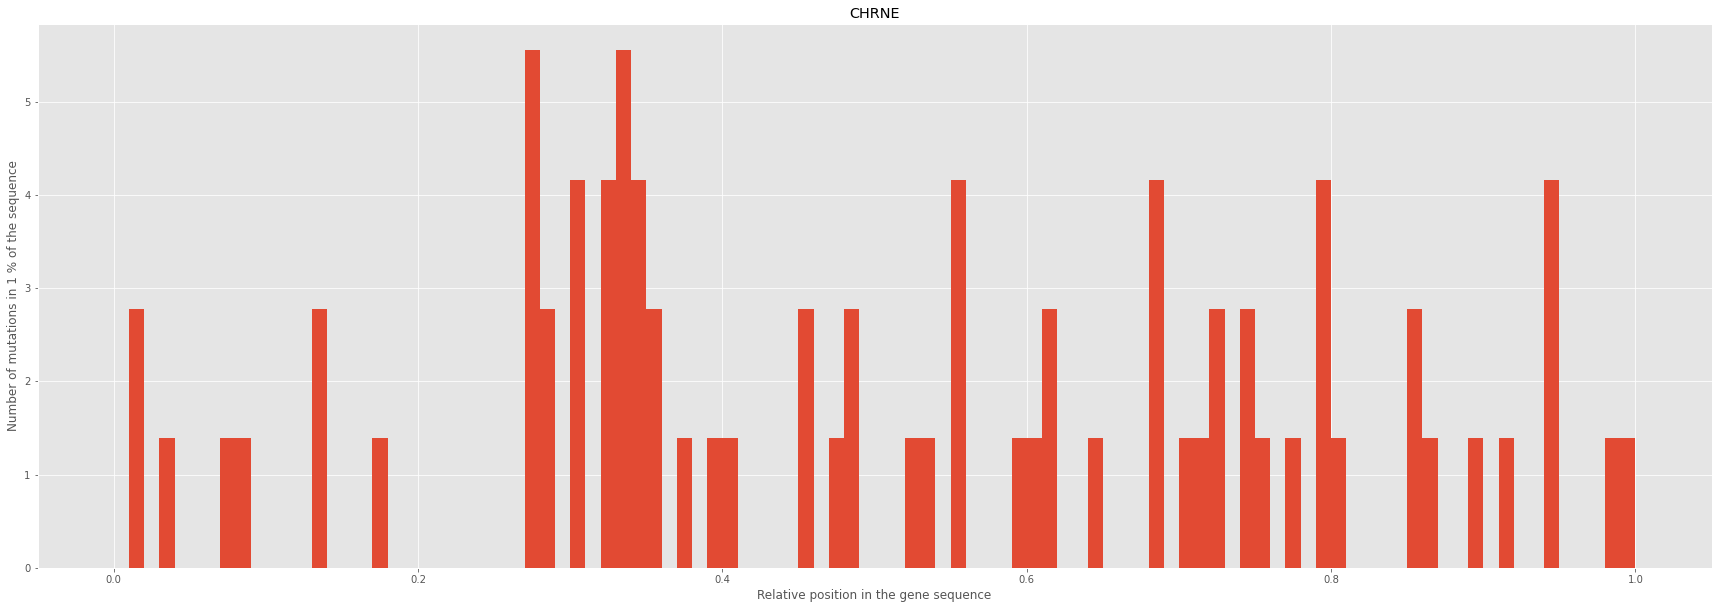

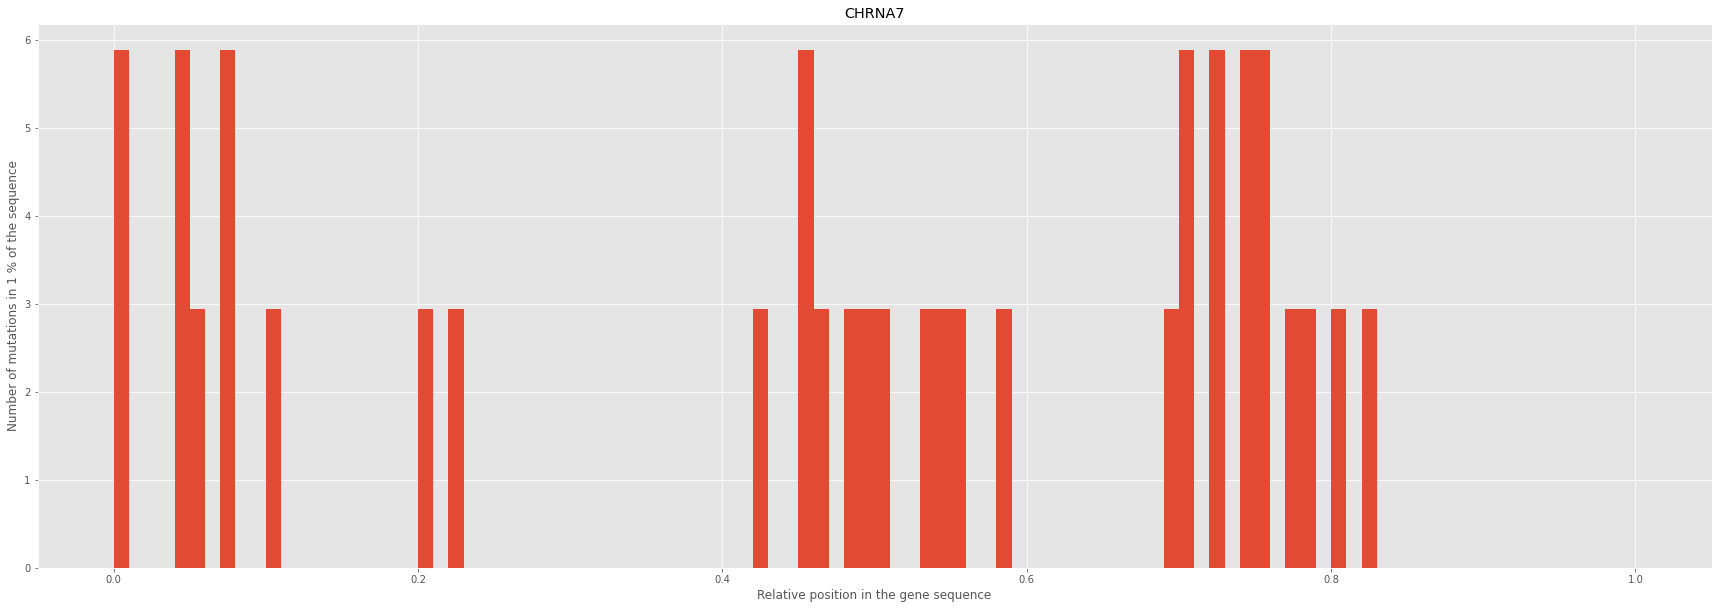

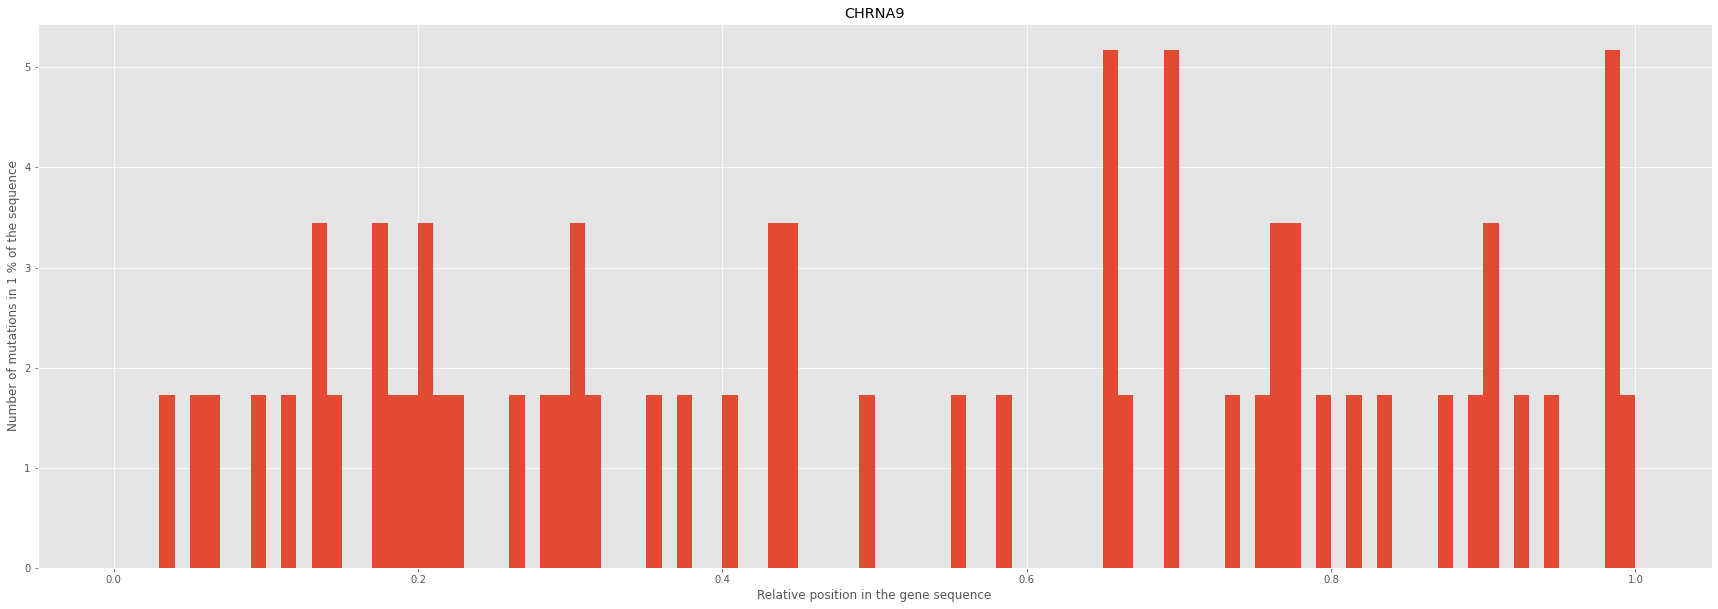

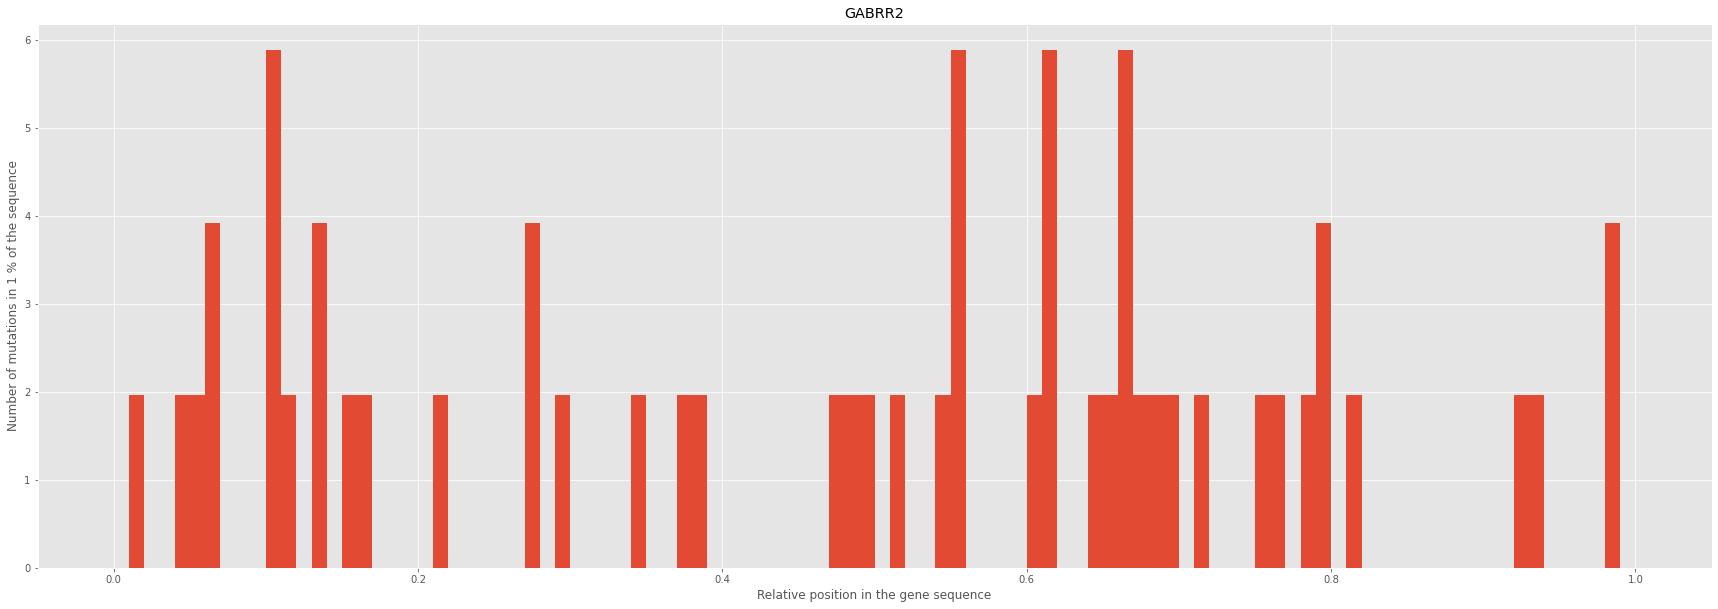

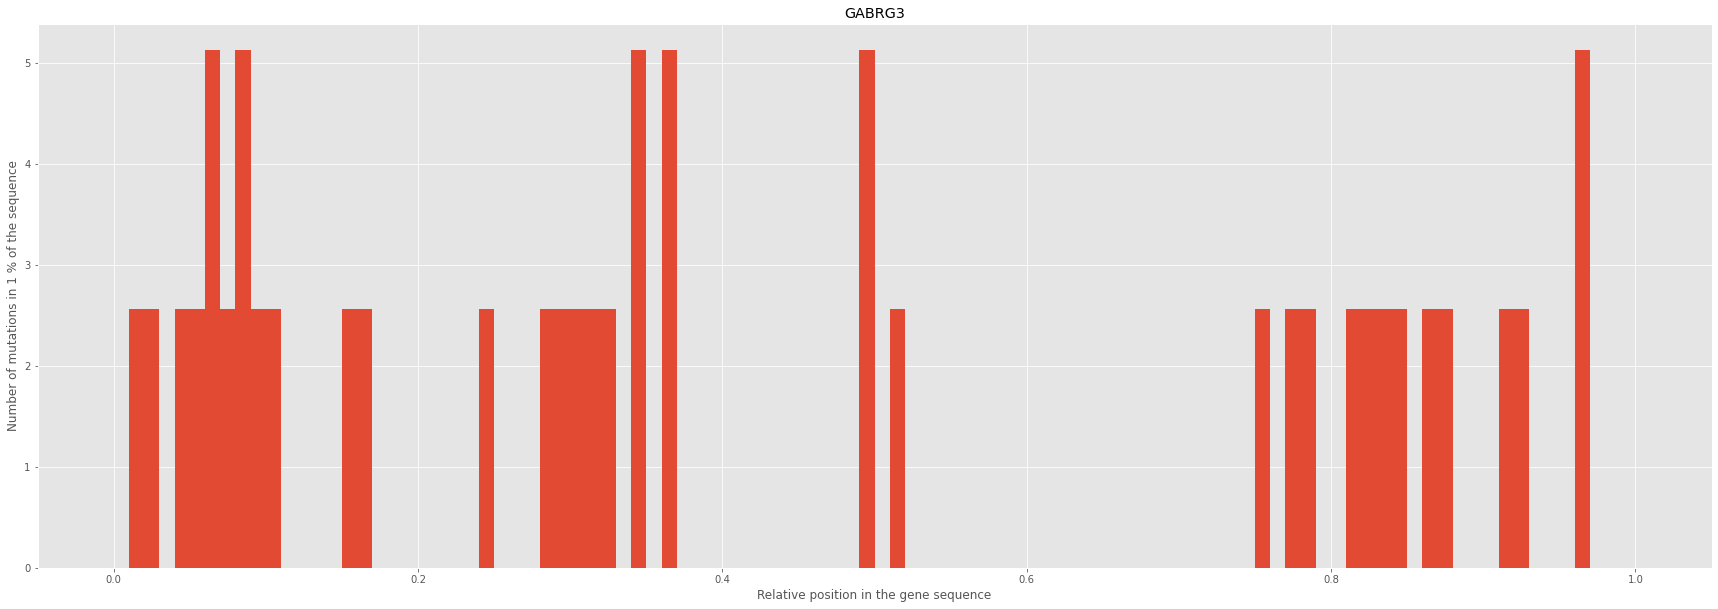

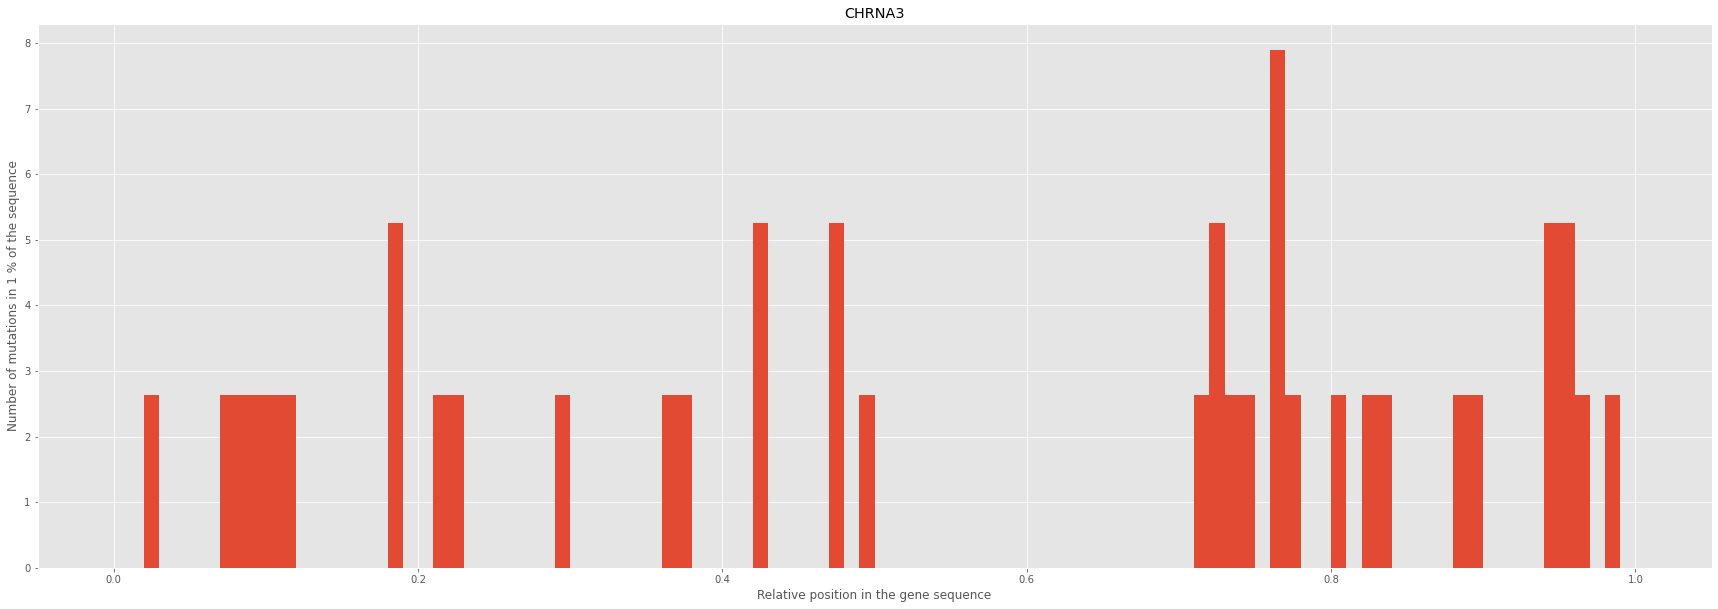

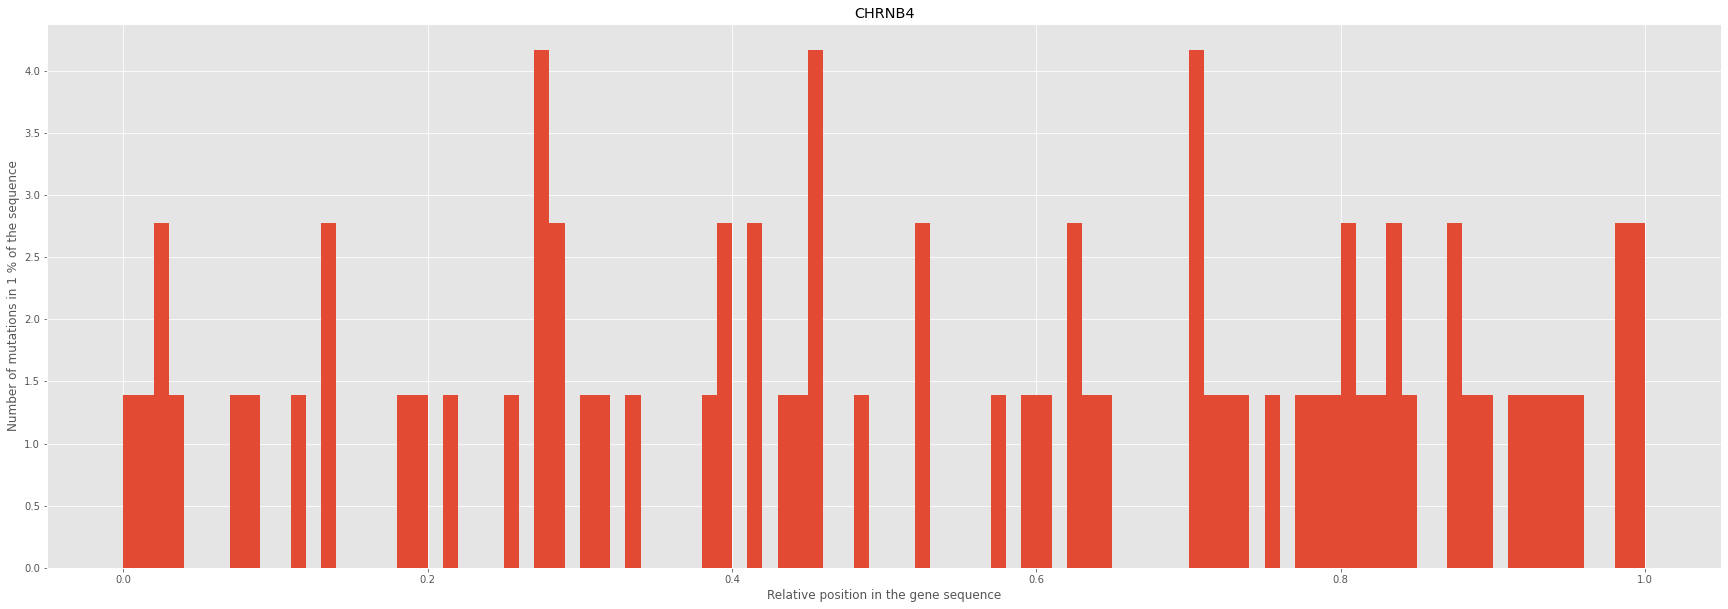

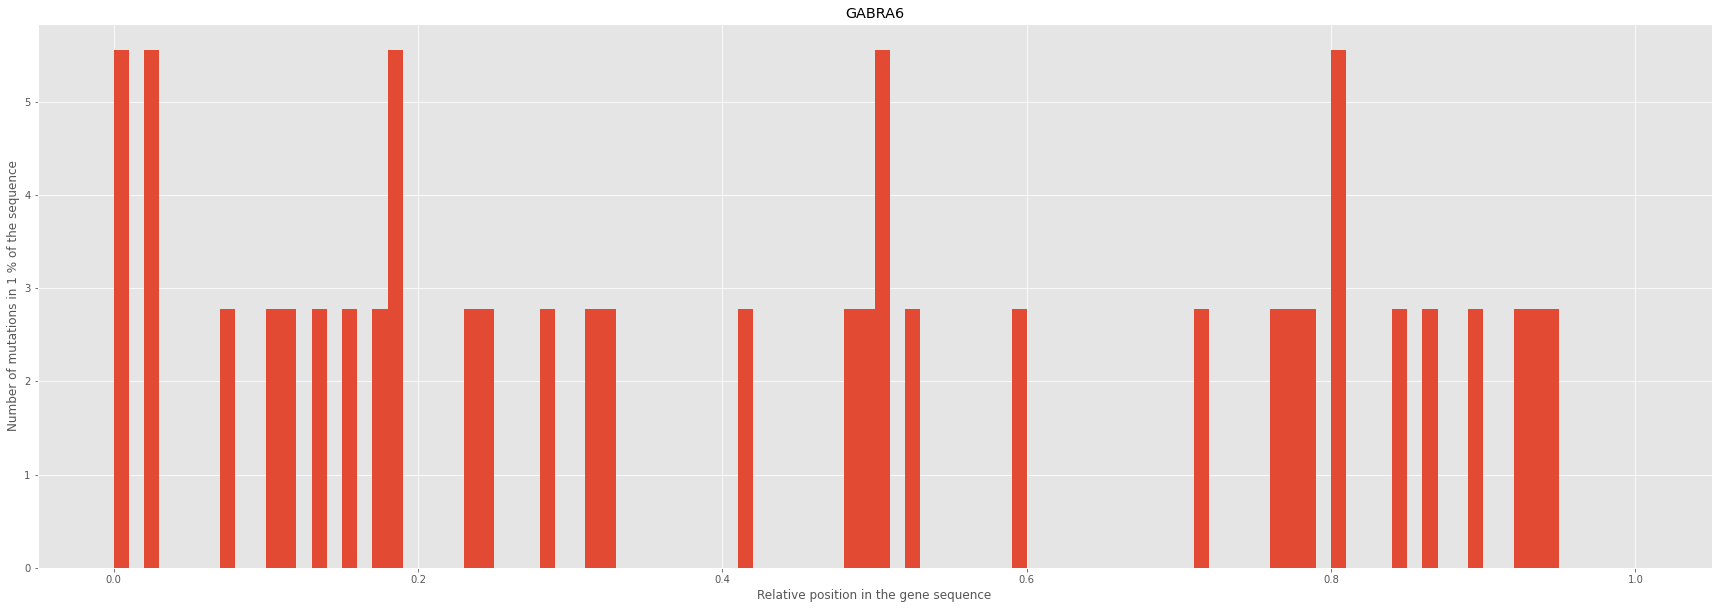

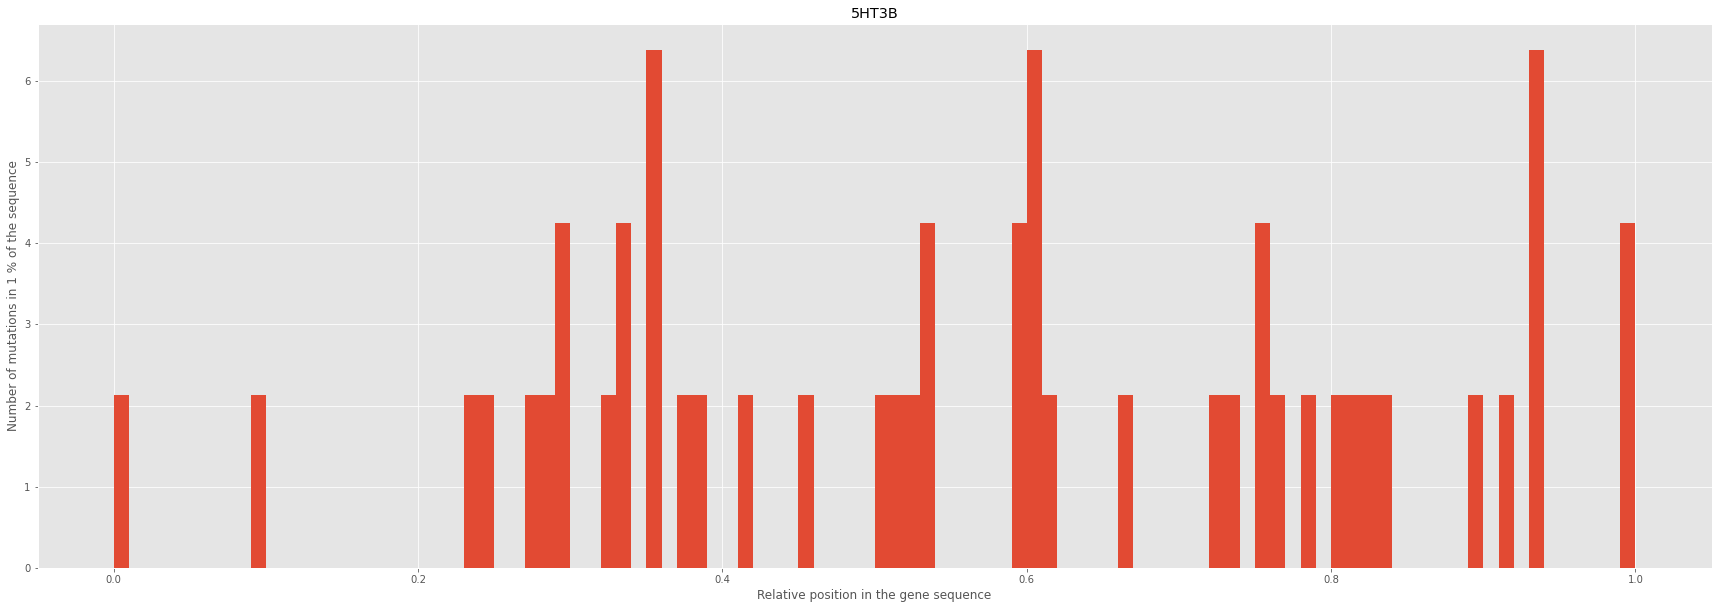

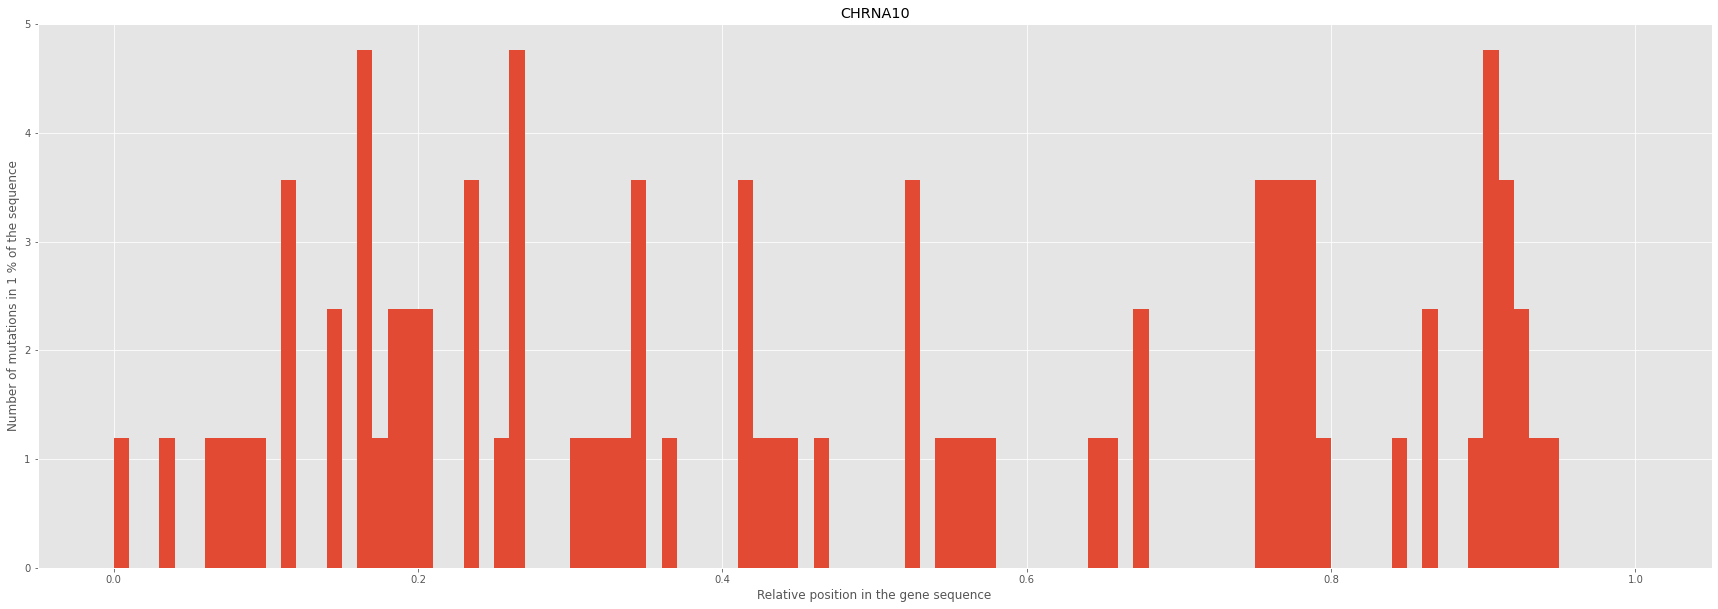

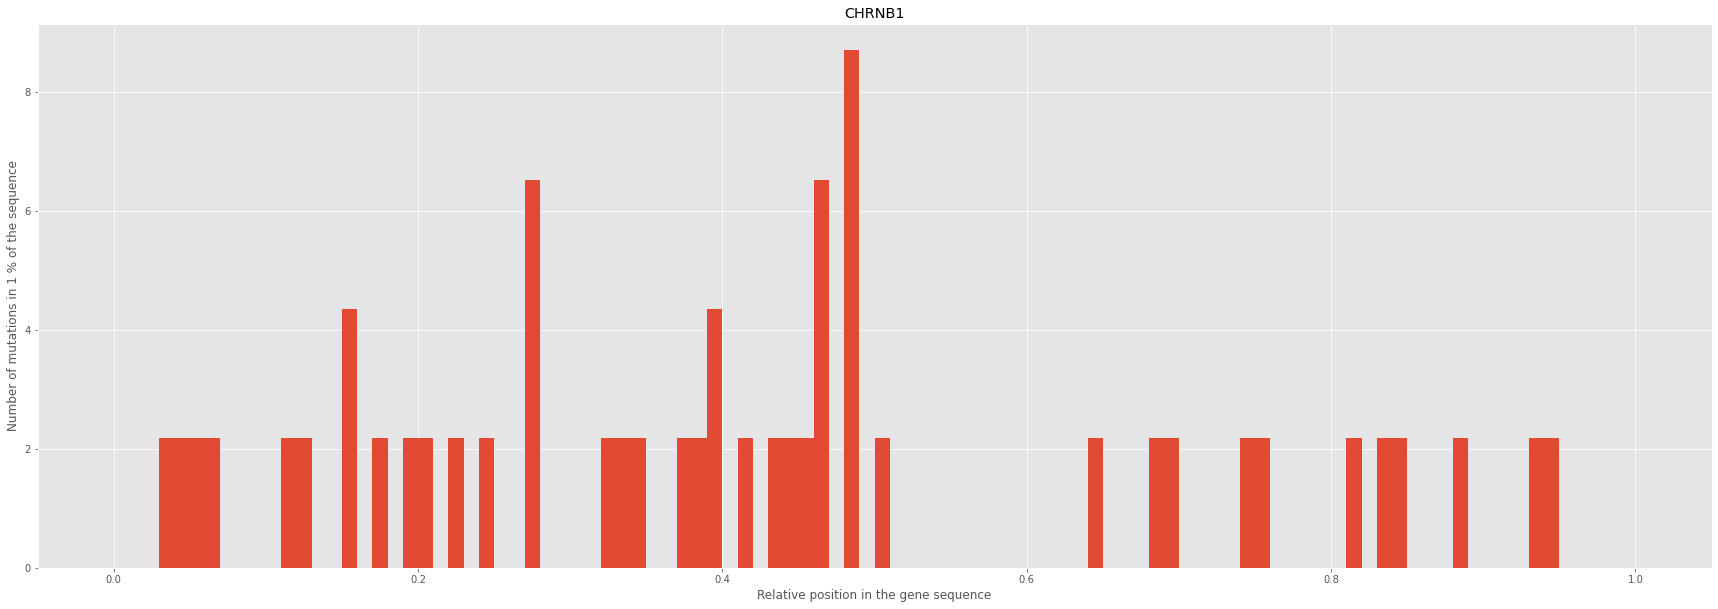

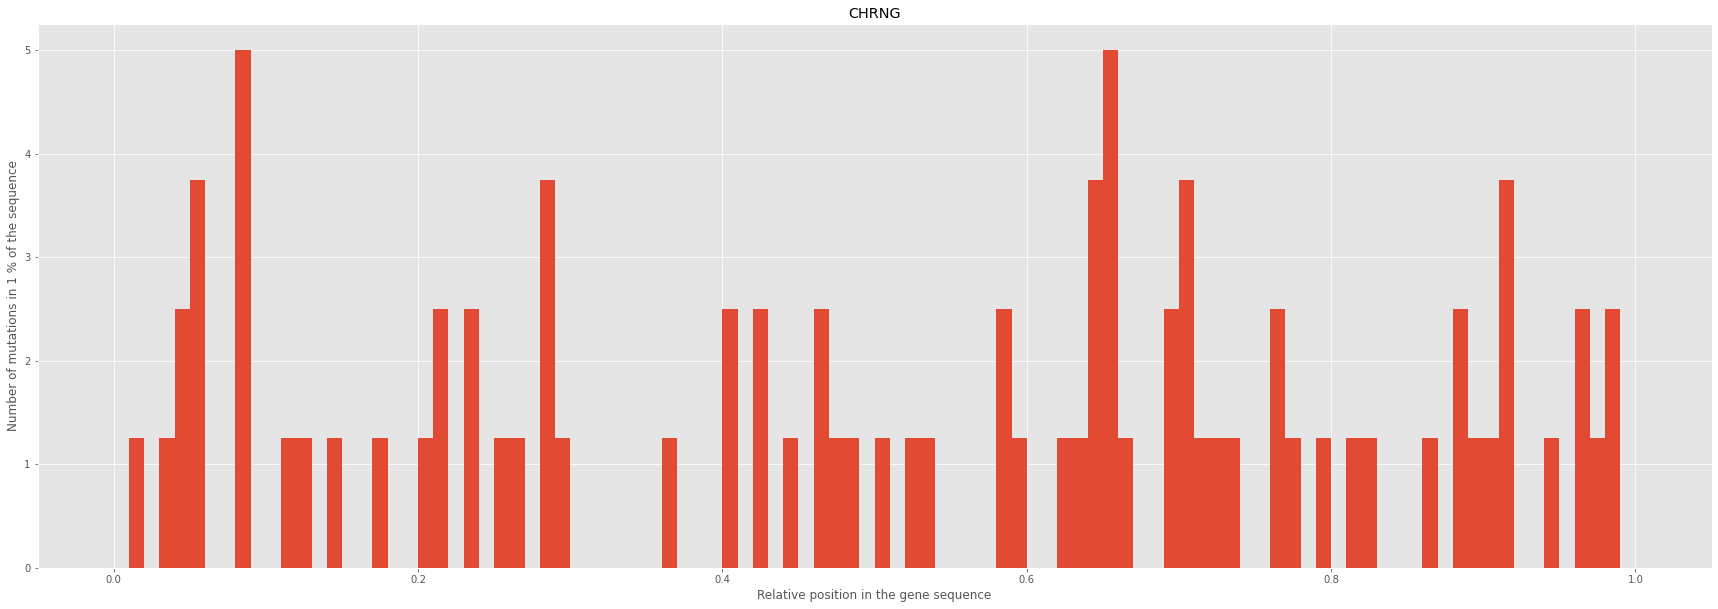

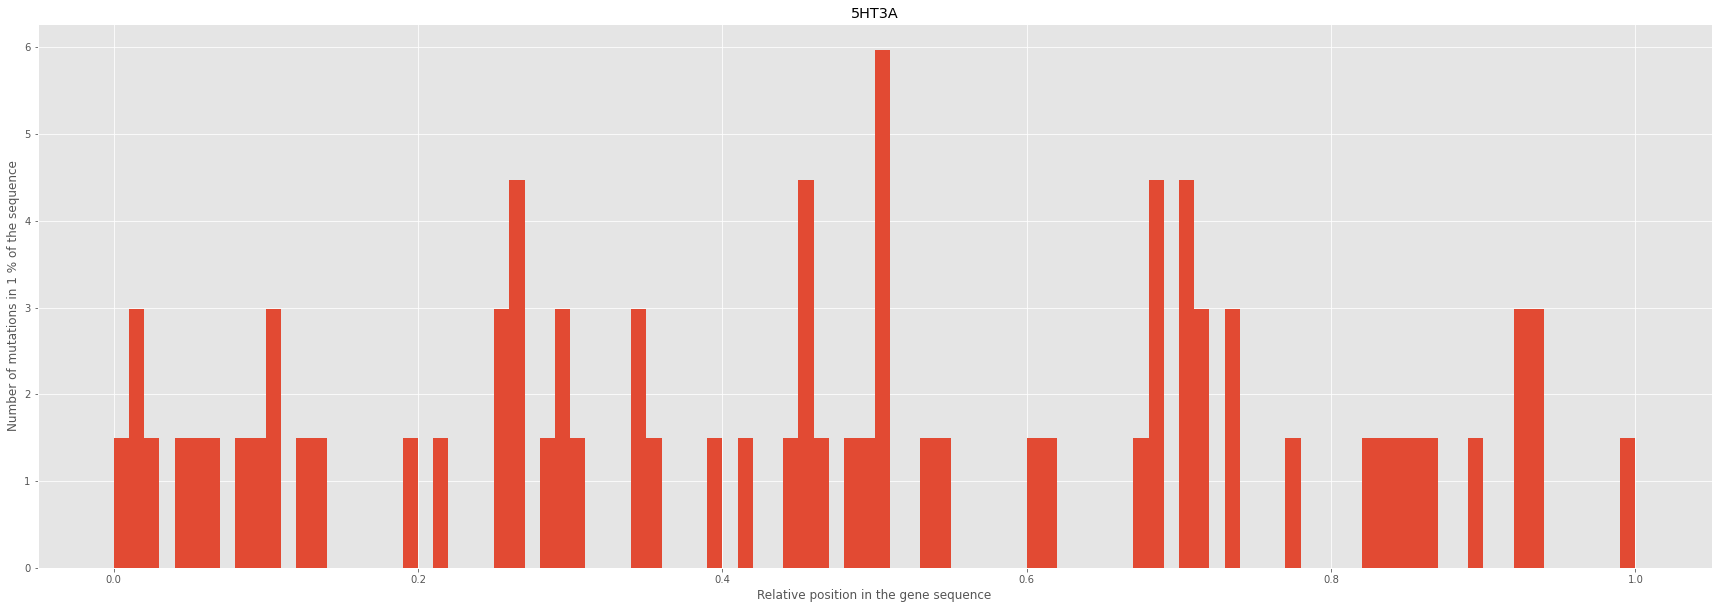

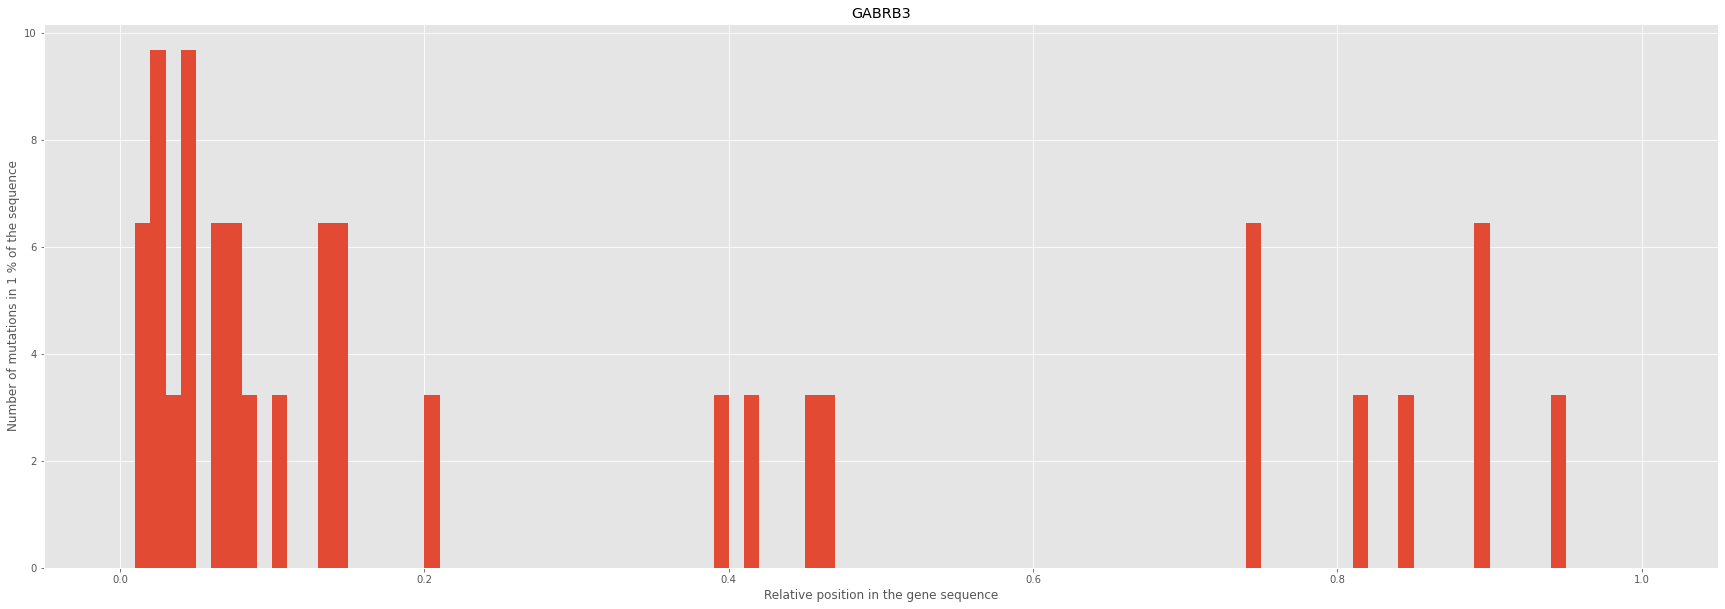

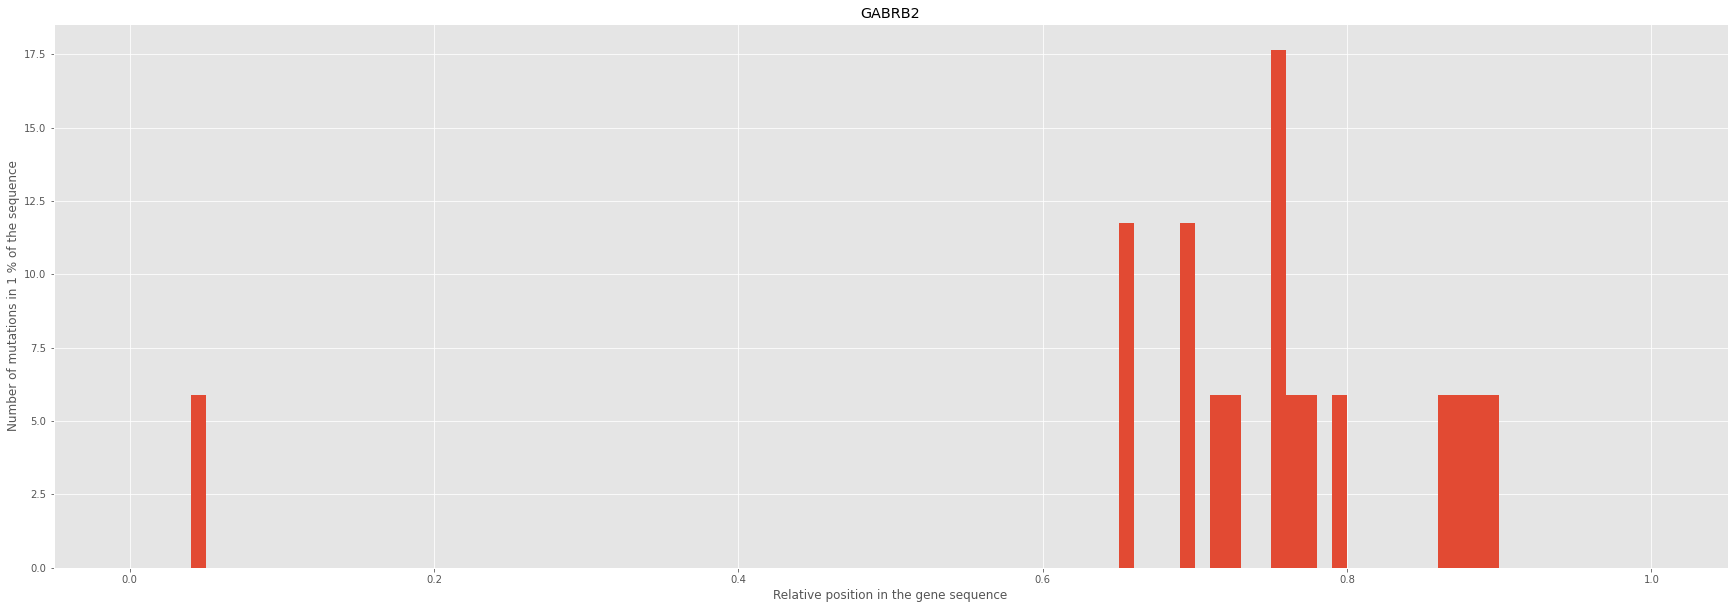

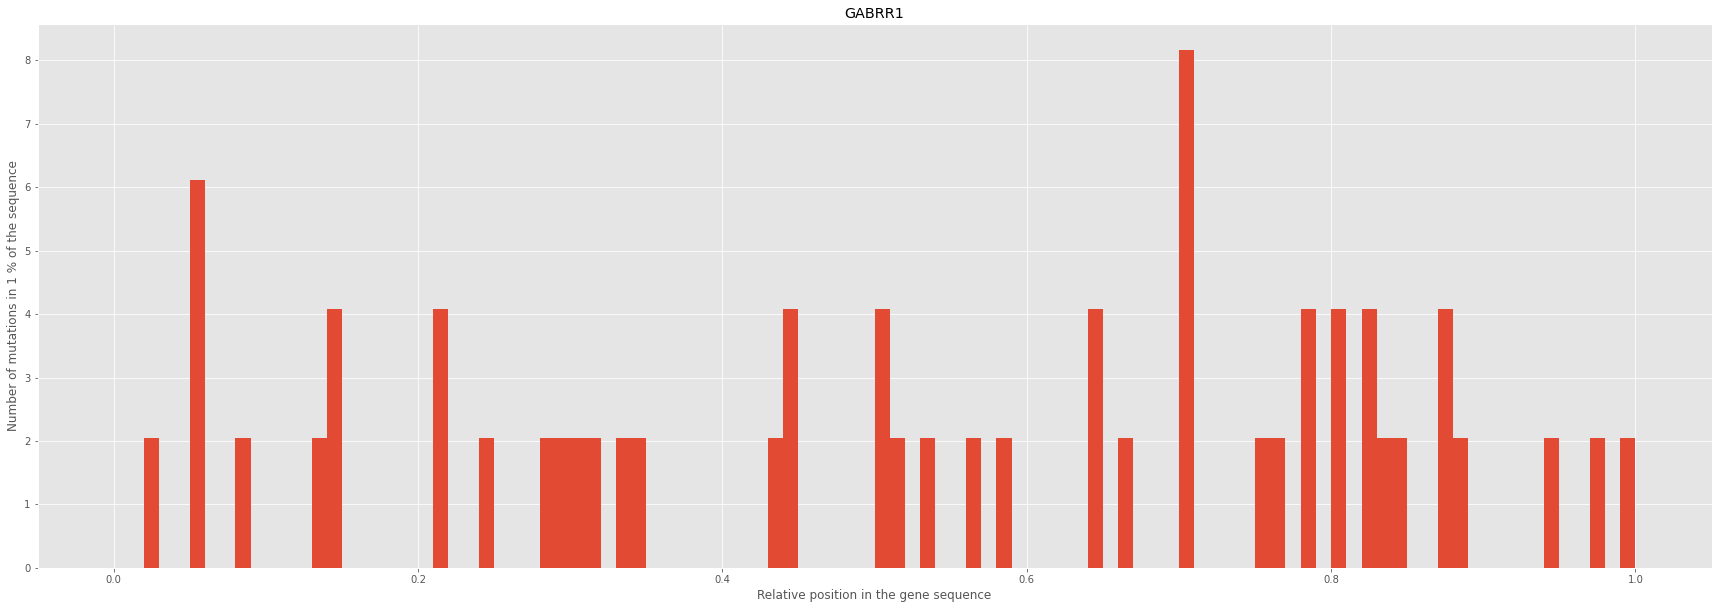

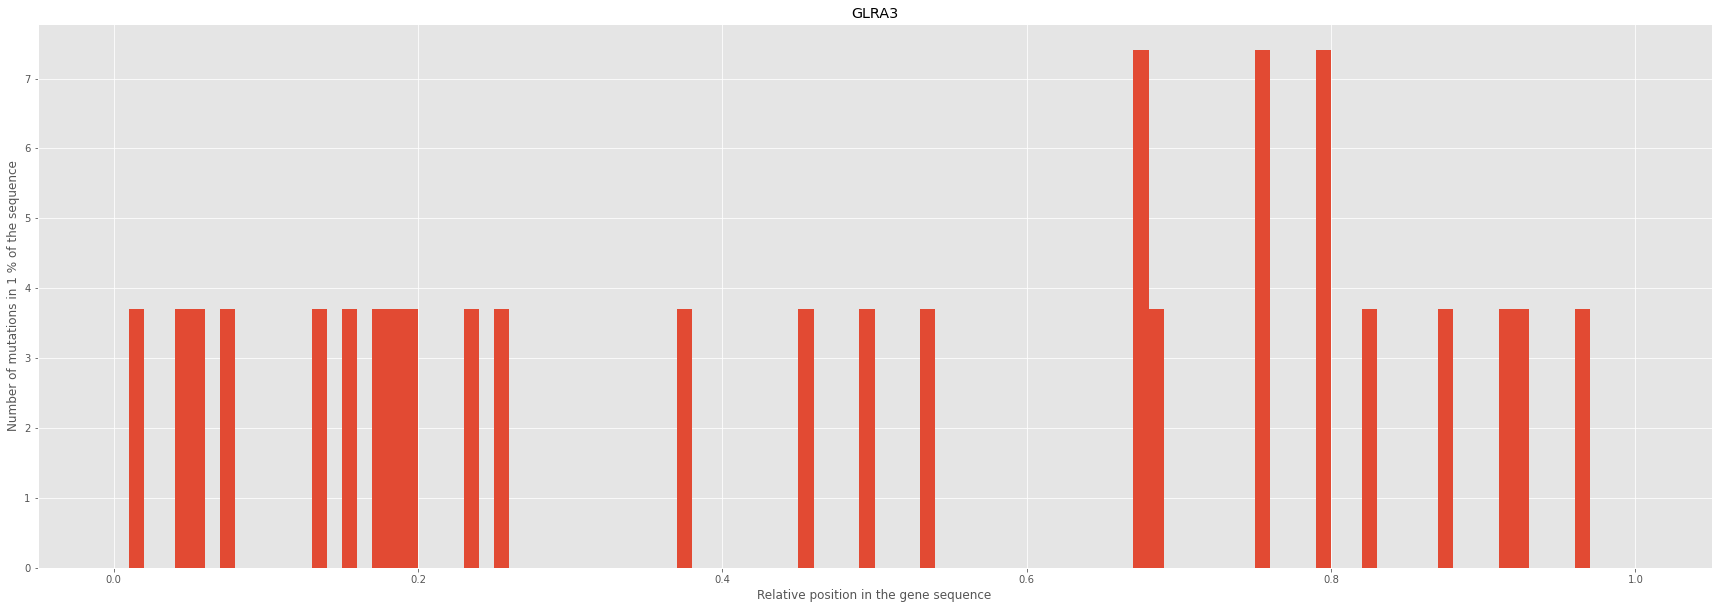

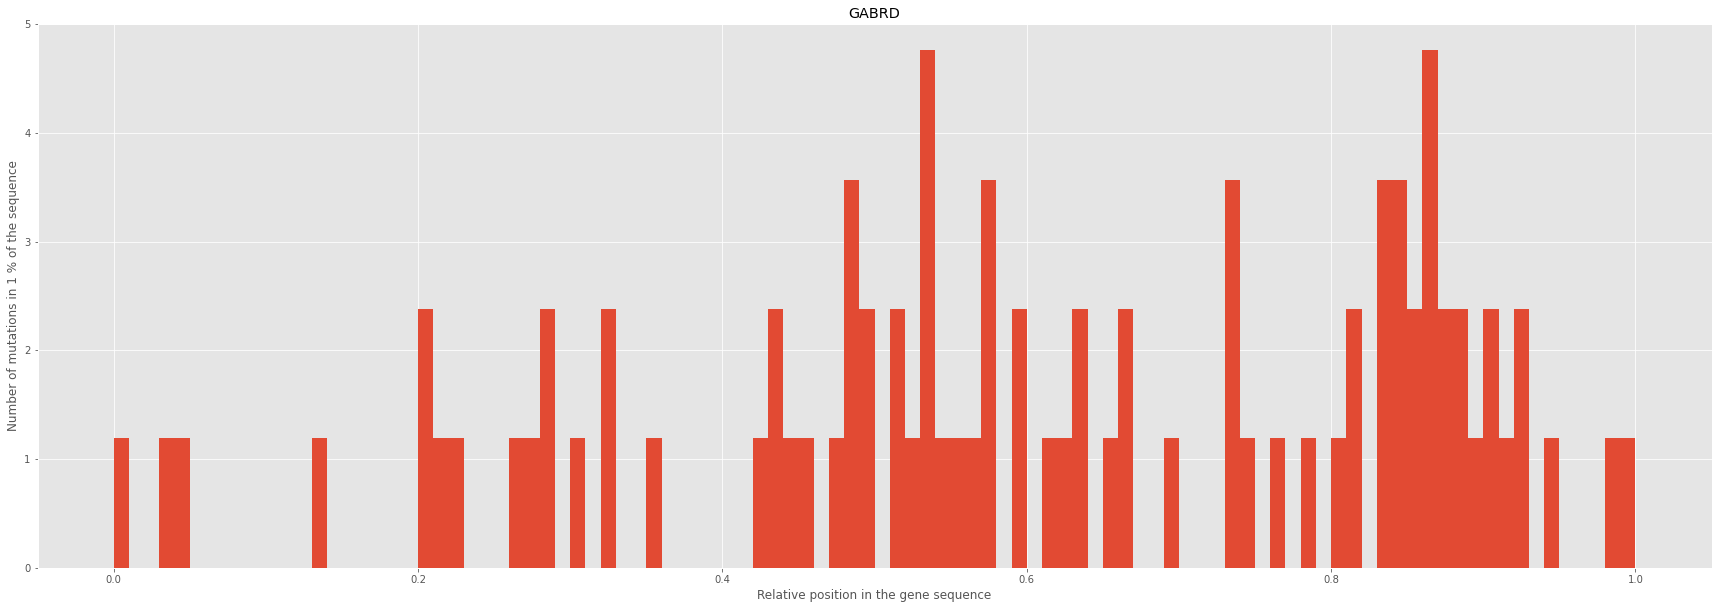

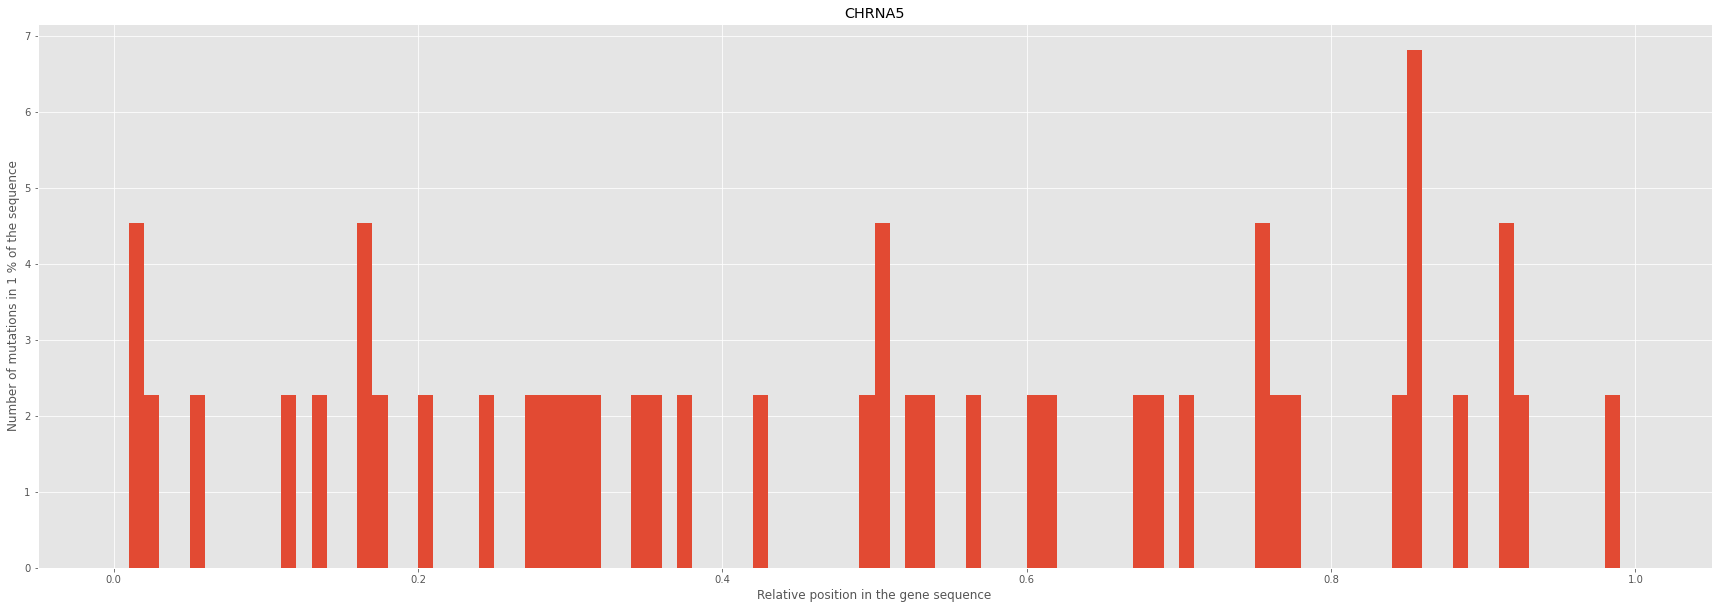

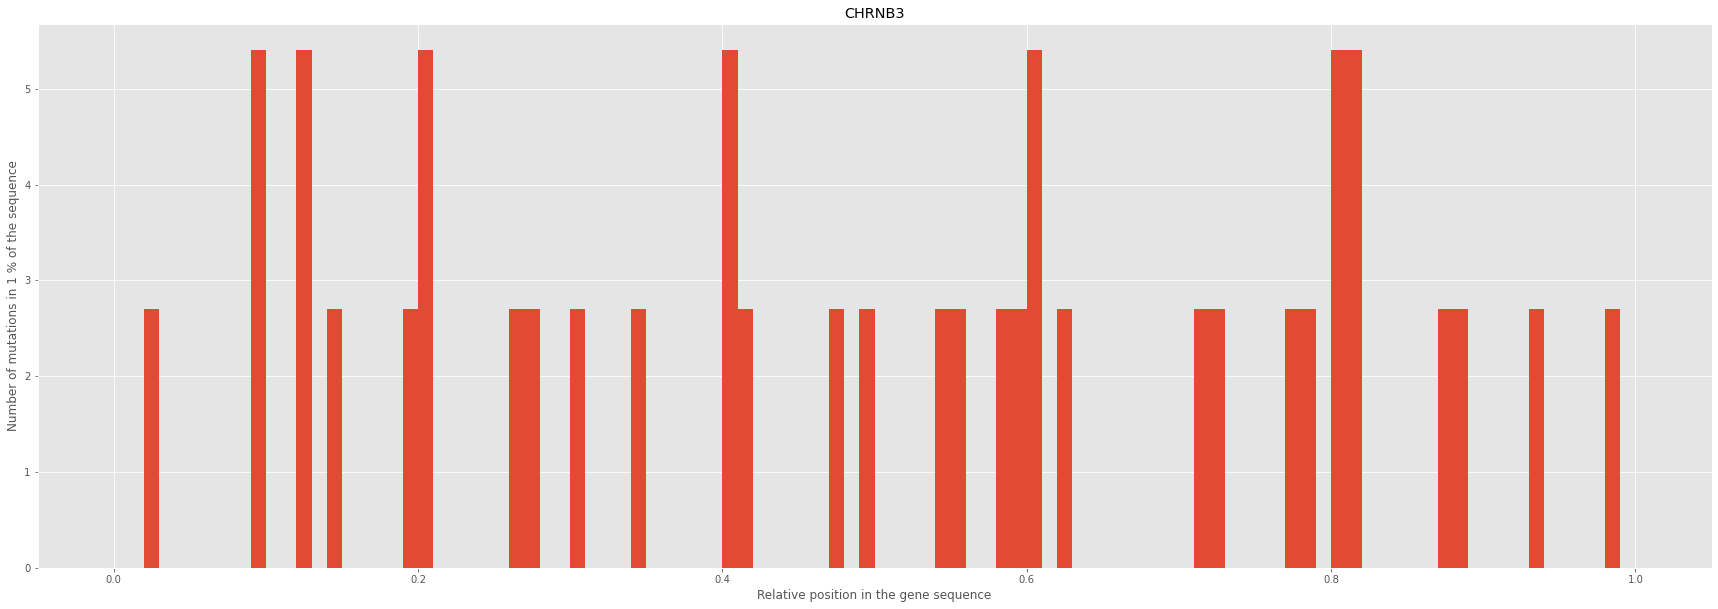

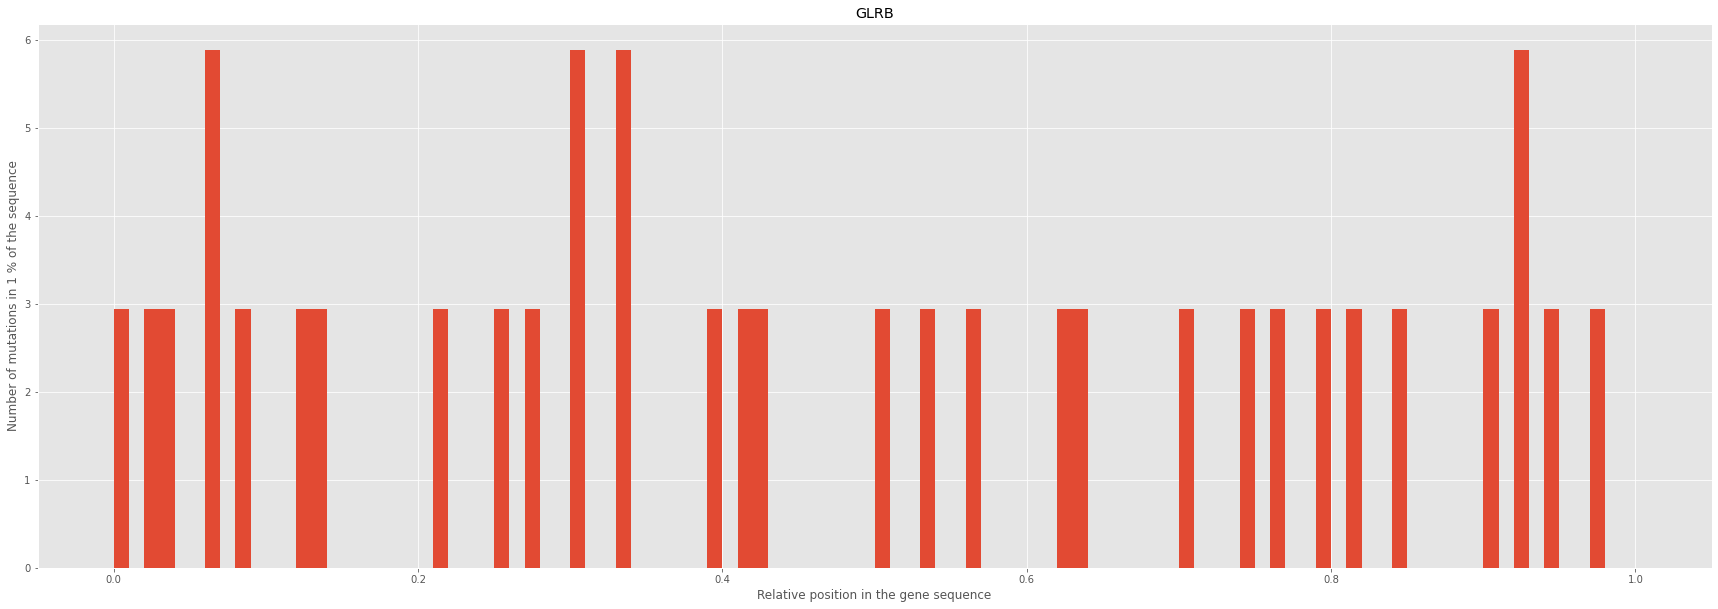

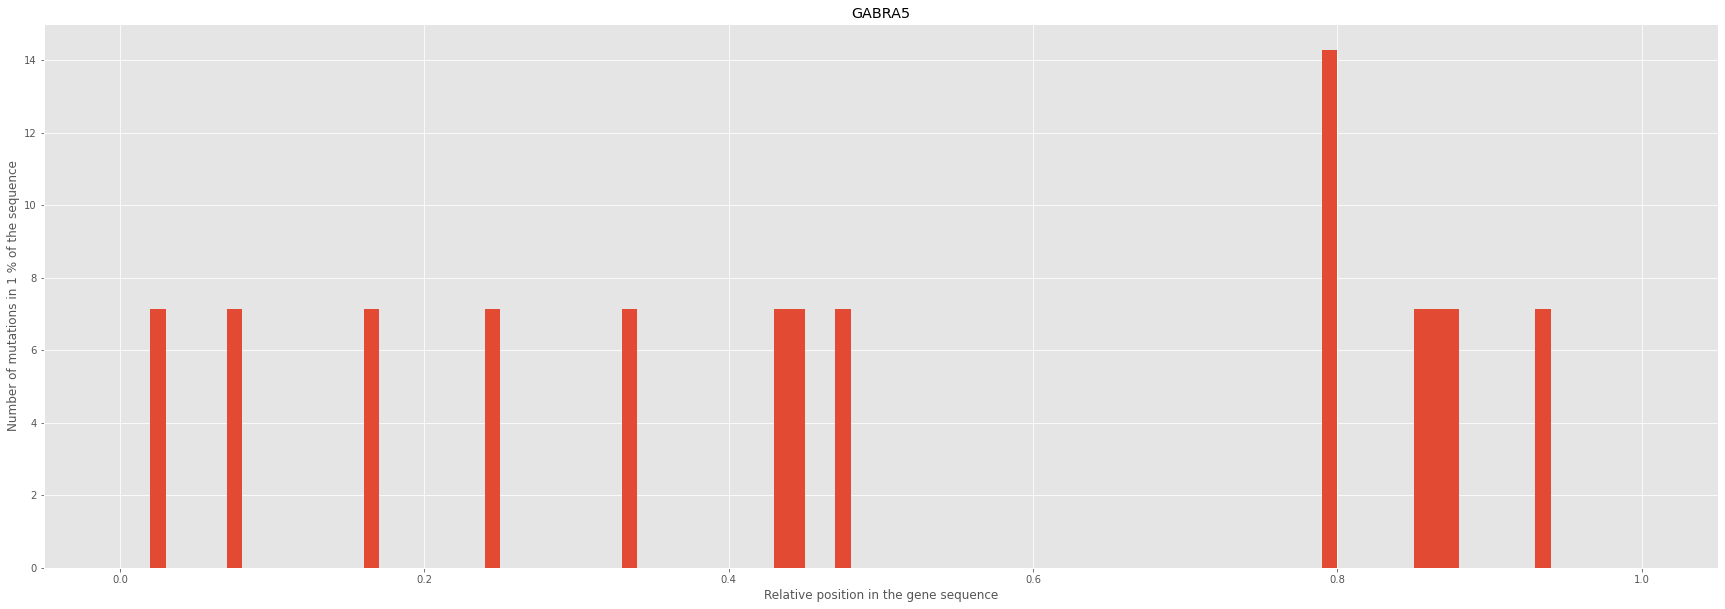

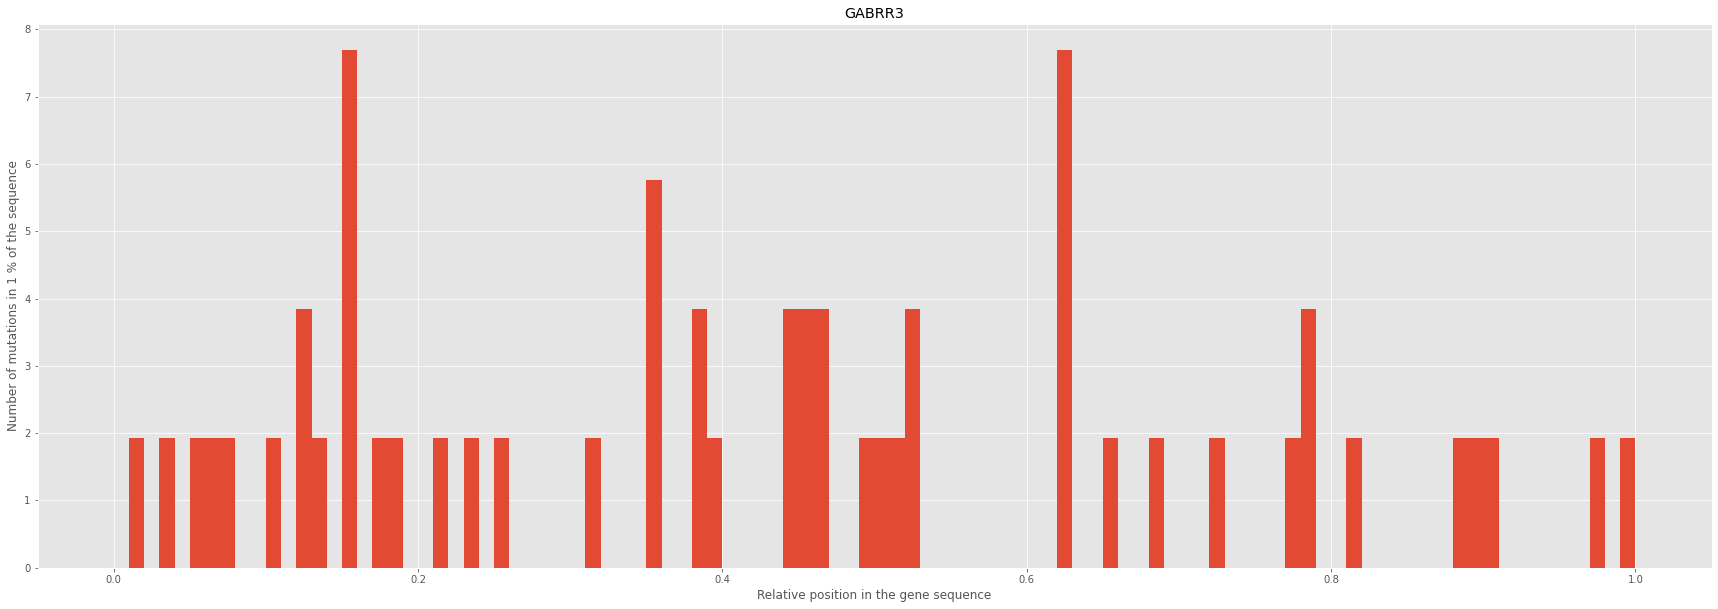

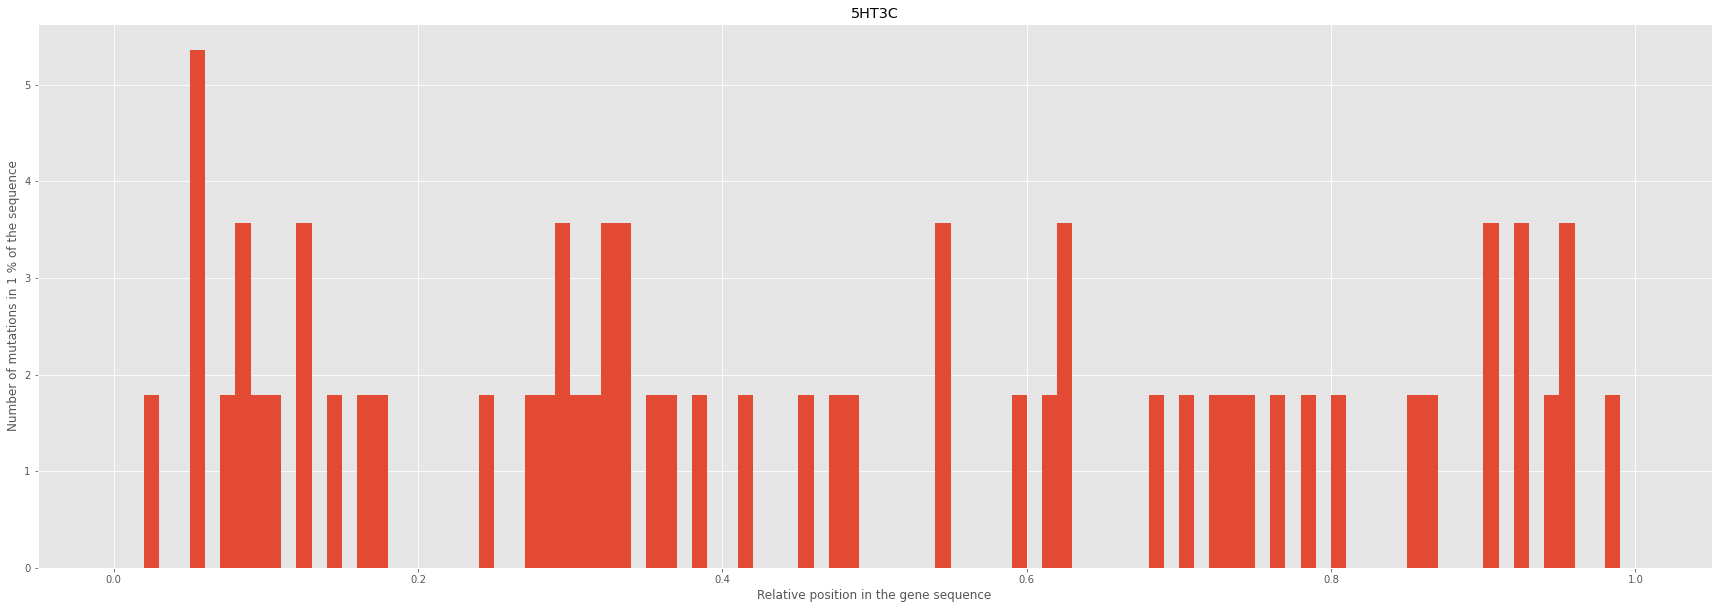

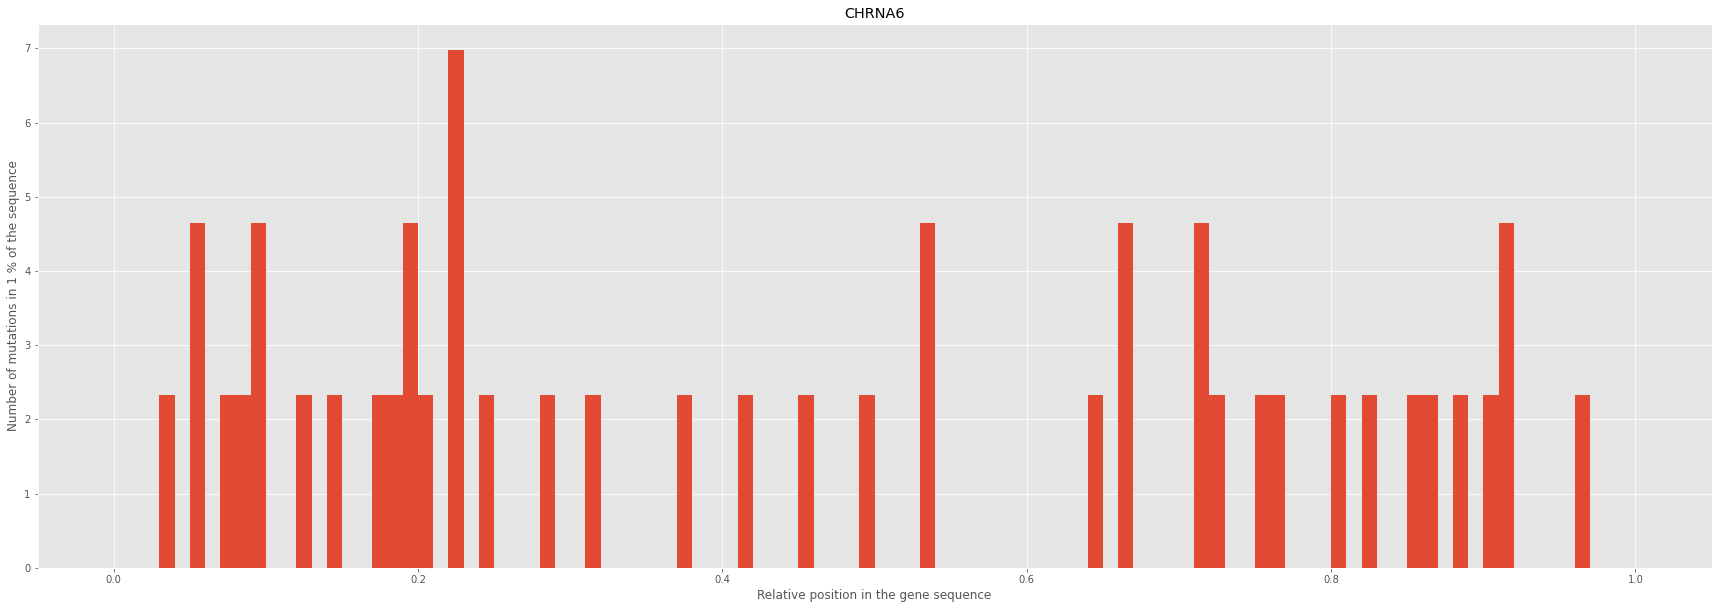

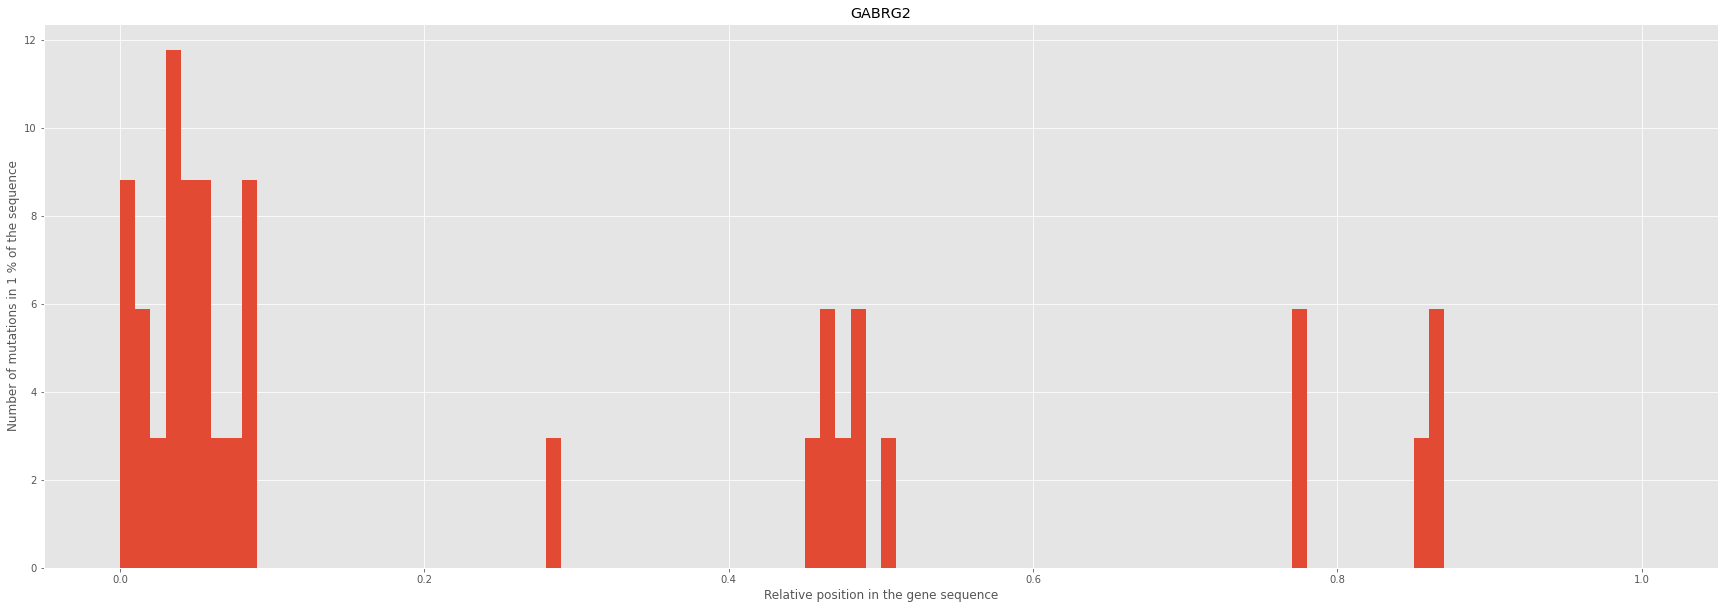

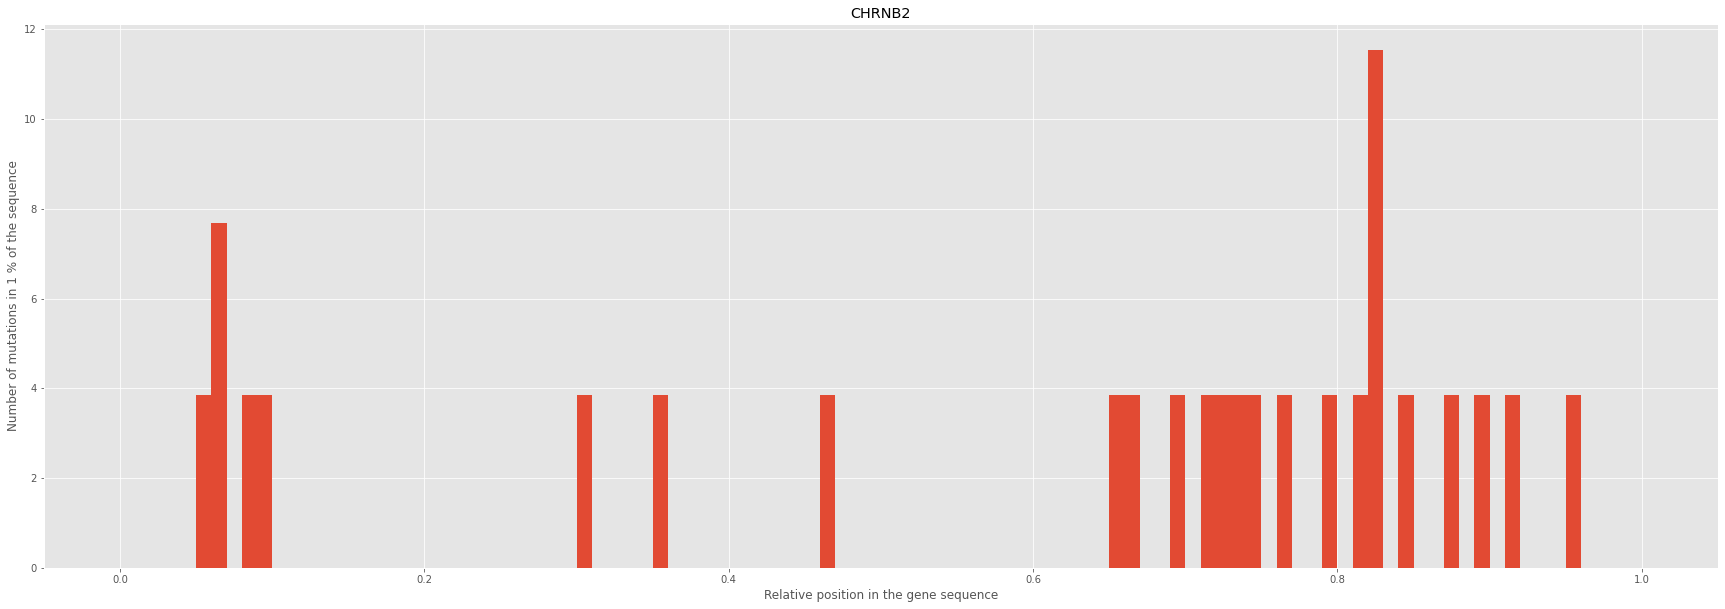

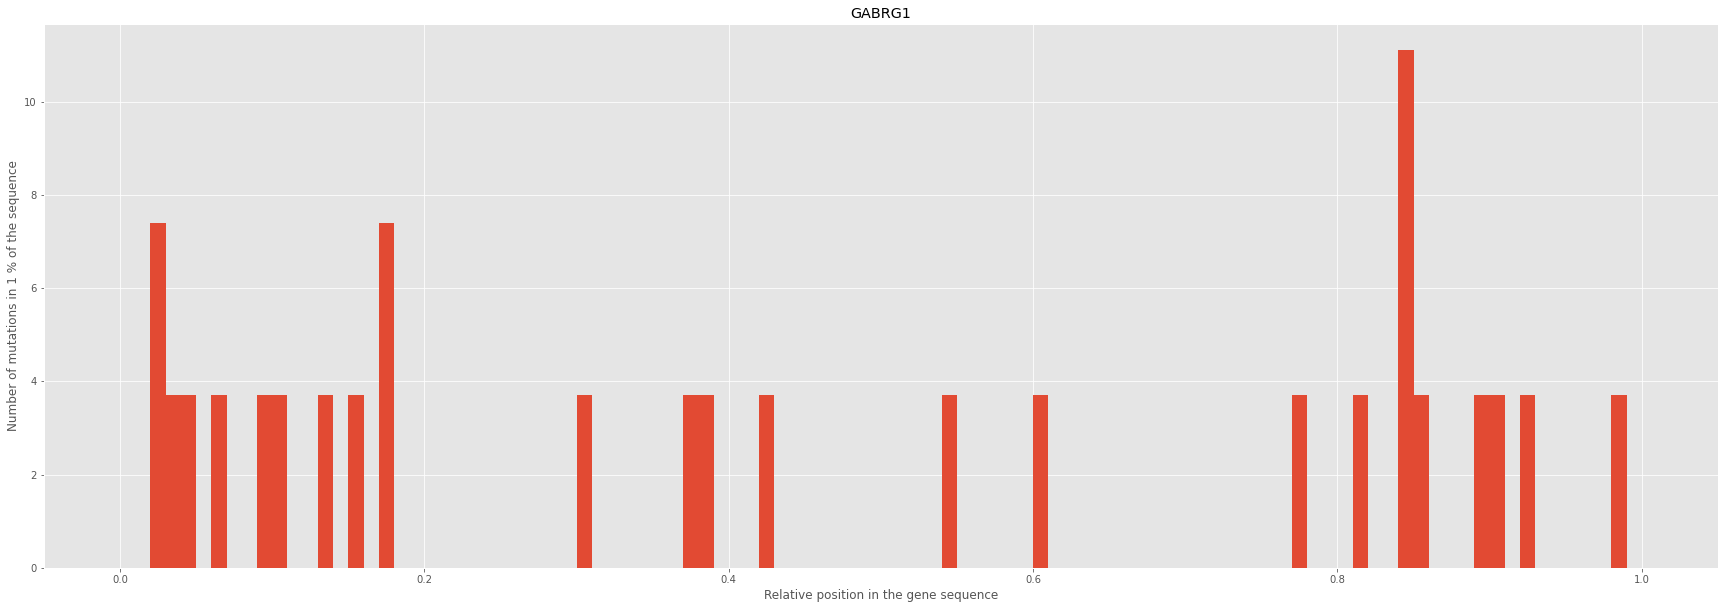

In [591]:
for gene in missense["Gene"].unique():
    pyplot.hist(missense["AA Relative"][missense["Gene"] == gene], bins=[x*0.01 for x in range(0, 101)], density=True)
    pyplot.xlabel("Relative position in the gene sequence")
    pyplot.ylabel("Number of mutations in 1 % of the sequence")
    pyplot.title(gene)
    pyplot.show()

## Mapping to a common alignment

### Producing the alignment
The alignment was produced through predicted structures by AlphaFold. The sequences used in the prediction are human reference sequences from UniProt, so the predicted structures should be complete. After fetching all the structures, these were imported into MOE session, where they were aligned. First, a global `optimized for superposition` alignment was performed. After that, sequence before the start of the first beta sheet and the domain between TM3 and TM4 were separately aligned with `sequence only alignment` option. These parts of structures are highly mobile, but are also less important for the comparison. As such, a sequence-based alignment is good enough.

Afterwards extra sequences were added for the proteins which had an unmappable mutations. This was necessary as the reference sequence for a lot of mutations is not the main sequence on UniProt. 

### Using the alignment

In [592]:
alignment = AlignIO.read("Alignment.aln", "clustal")

In [593]:
print(alignment)

Alignment with 133 rows and 1014 columns
--------------------------------------------...--- GABRA1
--------------------------------------------...--- GABRA1_02
--------------------------------------------...--- GABRA1_03
--------------------------------------------...--- GABRA1_04
--------------------------------------------...--- GABRA1_05
--------------------------------------------...--- GABRA2
--------------------------------------------...--- GABRA2_02
--------------------------------------------...--- GABRA2_03
--------------------------------------------...--- GABRA2_04
----------------------MIITQTSHCYMTSLGILFLINI...--- GABRA3
--------------------------------------------...--- GABRA4
--------------------------------------------...--- GABRA5
--------------------------------------------...--- GABRA6
--------------------------------------------...--- GABRA6_02
--------------------------------------------...--- GABRA6_03
--------------------------------------------...--- GABRA6_04
-

We create a class to encapsulate the alignment and pack in it all the functions we would need for interacting with it.

In [654]:
class Alignment:
    def __init__(self, alignment_file) -> None:
        self._alignment = AlignIO.read(alignment_file, "clustal")
        self._sequences = {sequence.id: sequence for sequence in self._alignment}
        self.alignment_subunits = self._sequences.keys()
    
    def convert_to_reference(self, id, acid, number):
        """
        Returns the position in the reference sequence (STARTING FROM 1) if found, else -1.
        The provided number also must start the amino acid count with 1.
        """
        if len(acid) == 3:
            acid = seq1(acid)

        sequence = self._sequences[id]

        # Edge case if the number is higher than the length of the sequence
        if number > len(str(sequence.seq).replace("-", "")):
            return -1

        i = 0
        for j, residue in enumerate(sequence):
            if residue != "-":
                i = i+1
                if i == number:
                    if residue == acid:
                        return j+1
                    else:
                        return -1

    def find_reference(self, gene, aacid, number):
        """
        Goes through all the internal isoforms of the selected gene and runs a reference run
        till it finds a match. Else it returns -1.
        """
        subunits = pandas.Series([sub for sub in self.alignment_subunits if gene in sub])
        result = subunits.apply(lambda x: self.convert_to_reference(x, aacid, number))
        return -1 if sum(result == -1) == len(result) else result[result != -1].iloc[0]
    
    def filter_sequence(self, group_isoforms=False):
        """
        Discards the positions of the alignment which are in the middle of 3 consequtive single-sequence occupied alignment subsequence.
        If group_isoforms is true it considers hits on multiple isoforms of the same gene as 1 hit. 
        """
        # self._original_sequences = self._sequences
        # self._original_alignment = self._alignment

        if group_isoforms:
            genes = pandas.Series([key for key in self._sequences.keys() if not "_" in key])
            # Note we pad the sequence with one 1 on each side. This is used just in the creation of the mask so we can properly process the first and last value
            sequence_count = numpy.pad(numpy.array([numpy.array([[y != "-" for y in ali_class._sequences[key]] for key in ali_class._sequences.keys() if gene in key]).any(axis=0) for gene in genes]).sum(axis=0), (1, 1), "constant", constant_values=1)
        else:
            sequence_count = numpy.array([1] + [len(self._alignment[:, i].replace("-", "")) for i in range(0, len(self._alignment[0]))] + [1])
        
        mask = numpy.array([(x > 1) or (y > 1) or (z > 1) for x, y, z in zip(sequence_count, sequence_count[1:], sequence_count[2:])])
        
        self.precomputed_filter = []
        j = 1
        for i, mask_value in enumerate(mask):
            if mask_value:
                self.precomputed_filter.append(j)
                j += 1
            else:
                self.precomputed_filter.append(-1)
    
    def convert_to_filtered(self, position):
        """"
        Takes the position in the reference sequence and converts it to the filtered reference position.
        If the position got discarded through filtering it returns -1.
        """
        return self.precomputed_filter[int(position)]

    def aa_to_filtered(self, gene, aacid, number):
        """
        Converts the amino acid to the filtered amino acid sequence using find_reference and convert_to_filtered.
        """
        referenced = self.find_reference(gene, aacid, number)
        if referenced != -1:
            referenced = self.convert_to_filtered(referenced)
        return referenced

In [655]:
ali_class = Alignment("Alignment.aln")

In [656]:
ali_class.find_reference("GABRA1", "T", 20) # Test; should be 51

88

In [657]:
ali_class.find_reference("GABRA1", "T", 23) # Test; should be -1

-1

In [658]:
missense["AA Referenced"] = missense.apply(lambda x: ali_class.find_reference(x["Gene"], x["Protein Consequence"].split(".")[1][0:3], x["AA Number"]), axis=1)

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



How many of the amino acids we could not map?

In [659]:
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]))
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]) / missense.shape[0])

# Check also NaN-s
print(sum(missense["AA Referenced"].isna()))

28
0.014227642276422764
0


For some SNPs the change in reference genome assembly changed the protein change assignment to an incorrect one. We use the GnomAD v2 assignments in the cases where there is an entry present. Where this also doesn't yield the correct assignment we use the alternative alignments to see if the mutation might have been mapped onto a non-main transcript.

In [660]:
for i in range(0, missense.shape[0]-1):
    if missense.iloc[i]["AA Referenced"] == -1:
        if missense.iloc[i]["rsIDs"] is None:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["Transcript Consequence"] == missense.iloc[i]["Transcript Consequence"])]
        else:
            x = dataset_alternative[(dataset_alternative["Gene"] == missense.iloc[i]["Gene"]) & (dataset_alternative["rsIDs"] == missense.iloc[i]["rsIDs"])]
        if not x.empty and x["Protein Consequence"].any():
            missense.at[i, "AA Referenced"] = ali_class.find_reference(missense.iloc[i]["Gene"],
                                                    x["Protein Consequence"].str.split(".").values.tolist()[0][1][0:3],
                                                    x["Protein Consequence"].str.extract(r"[a-zA-Z]([0-9]+)[a-zA-Z]").astype("int32").values.tolist()[0][0])

In [661]:
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]))
print(-sum(missense["AA Referenced"][missense["AA Referenced"] == -1]) / missense.shape[0])

13
0.0066056910569105695


We managed to reduce the number of non-mapped mutations significantly. We could live with 19 if they are somewhat distributed across several genes and the total pool of mutations is high enough. 

Let's see the distribution throught the genes.

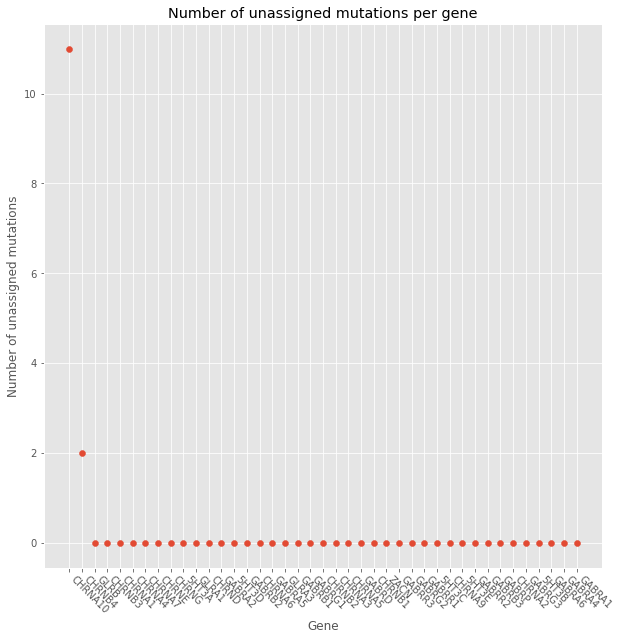

In [662]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.scatter(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Number of unassigned mutations")
pyplot.title("Number of unassigned mutations per gene")
pyplot.show()

Let's see how this translates into the proportion of the individual gene mutations that are unasigned.

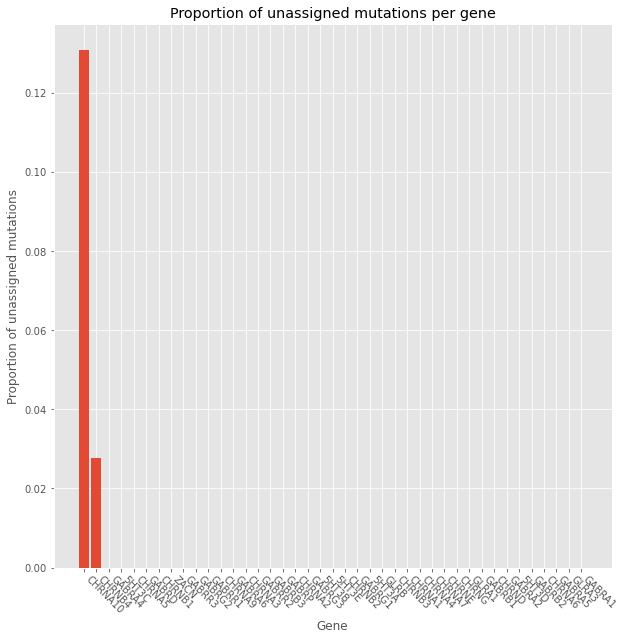

In [663]:
_values["AA Unreferenced"] = _values.apply(lambda x: -sum(missense["AA Referenced"][(missense["AA Referenced"] == -1) & (missense["Gene"] == x["Gene"])]) / sum(missense["Gene"] == x["Gene"]), axis=1)
_values.sort_values(by="AA Unreferenced", ascending=False, inplace=True, ignore_index=True)

pyplot.bar(_values["Gene"], _values["AA Unreferenced"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Gene")
pyplot.ylabel("Proportion of unassigned mutations")
pyplot.title("Proportion of unassigned mutations per gene")
pyplot.show()

**Note:**

- CHRNA10: has an extra protein coding transcript, which cannot be reliably áligned to the main transcript, so we cannot add it.
- CHRNB4: we already aligned all the transcript we could
- very short sequences (<100 AA) were automatically excluded

We have for now 0.9 % of SNPs where the numbering of amino acid was incorrect. We might reduce this through adding `extra sequences` or through `manual search`. Is the latter one worth it though?

For now we check where we find the variants in the reference sequence. There seem to be several hot spots. Note that the parts without signal don't necessarily mean a spot that is mutation-free, but might be a part of the protein that is tolerating the mutations better.

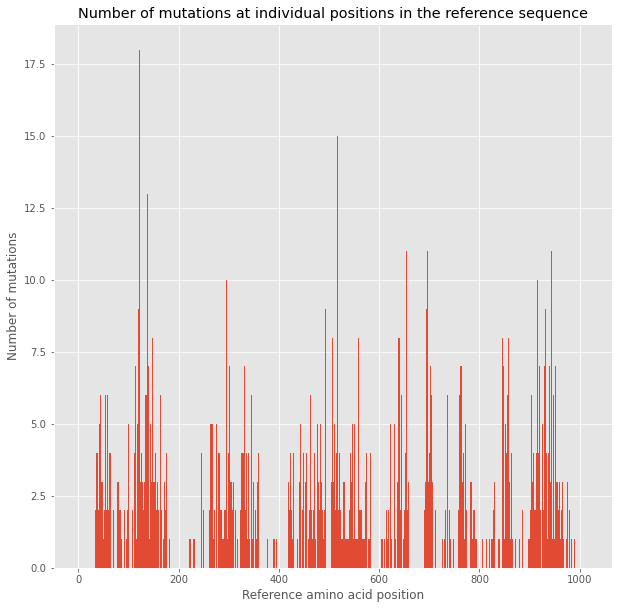

In [664]:
found_missense = missense[missense["AA Referenced"] != -1]
pyplot.hist(found_missense["AA Referenced"], bins=[x for x in range(1, len(alignment[0]))])
pyplot.xlabel("Reference amino acid position")
pyplot.ylabel("Number of mutations")
pyplot.title("Number of mutations at individual positions in the reference sequence")
pyplot.show()

Just in case we will also take only one mutation per amino acid, so we can see where multiple genes get mutated.

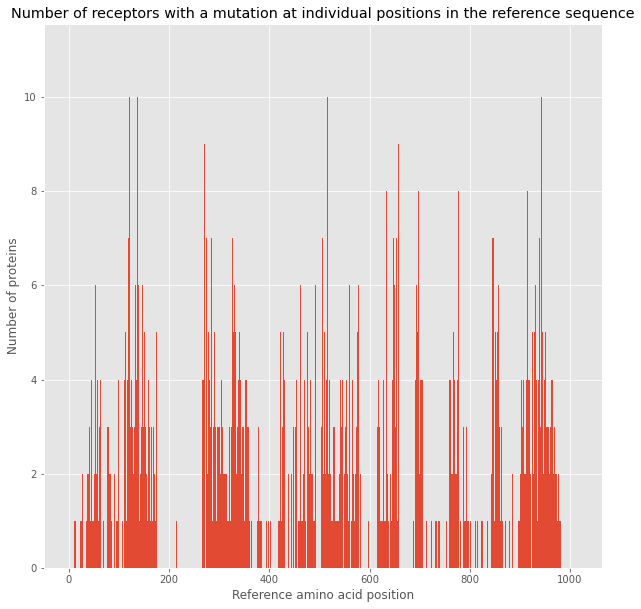

In [665]:
_unique_aas = []
for gene in found_missense["Gene"].unique():
    _unique_aas.extend(found_missense["AA Referenced"][found_missense["Gene"] == gene].unique())
pyplot.hist(_unique_aas, bins=[x for x in range(1, len(alignment[0]))])
pyplot.xlabel("Reference amino acid position")
pyplot.ylabel("Number of proteins")
pyplot.title("Number of receptors with a mutation at individual positions in the reference sequence")
pyplot.show()

## Mapping to structural elements
We have a list of the amino acids involved in the structural elements written in a CSV file. We load them in, transform them to the reference numbering and use them as a reference to annotate the table of mutations.

In [666]:
structural_elements = pandas.read_csv("Structural_elements.csv")
structural_elements

,Gene,AA Name,AA Number,BS
0,GABRA1,Y,252,TM1
1,GABRA1,F,253,TM1
2,GABRA1,V,254,TM1
3,GABRA1,I,255,TM1
4,GABRA1,Q,256,TM1
...,...,...,...,...
394,GABRA1,S,417,ICD
395,GABRA1,K,418,ICD
396,GABRA1,I,419,ICD
397,GABRA1,D,420,ICD


First we need to put our amino acids on the reference sequence. We apply it to every row in the table.

In [667]:
structural_elements["AA Referenced"] = structural_elements.apply(lambda x: ali_class.find_reference(x["Gene"], x["AA Name"], x["AA Number"]) , axis=1)
structural_elements

,Gene,AA Name,AA Number,BS,AA Referenced
0,GABRA1,Y,252,TM1,521
1,GABRA1,F,253,TM1,522
2,GABRA1,V,254,TM1,523
3,GABRA1,I,255,TM1,524
4,GABRA1,Q,256,TM1,525
...,...,...,...,...,...
394,GABRA1,S,417,ICD,939
395,GABRA1,K,418,ICD,940
396,GABRA1,I,419,ICD,941
397,GABRA1,D,420,ICD,942


We convert different structural elements to ranges by finding their minimum and maximum number. We use these to apply ranges to the data table. This way each variant in the data table has a structural element assigned to it. Note the structural elements don't overlap. Furthermore, the transmembrane domain is separated into it's 4 alpha helices. We can also see that some variants remain unclassified. 

In [668]:
found_missense["Region"] = ""
for element in structural_elements["BS"].unique():
    found_missense["Region"][(found_missense["AA Referenced"] > min(structural_elements["AA Referenced"][structural_elements["BS"] == element])) & (found_missense["AA Referenced"] < max(structural_elements["AA Referenced"][structural_elements["BS"] == element]))] = element

found_missense["Region"].unique()

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['', 'ECD', 'ICD', 'TM4', 'TM3', 'TM2', 'TM1'], dtype=object)

In [669]:
found_missense[found_missense["Region"] == "TM1"]

,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Count European (non-Finnish),Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript,AA Number,AA Relative,AA Referenced,Region
86,1484,2022,5,170808671.0,rs373064332,G,A,gnomAD Genomes,NaN,PASS,...,1.0,68004.0,0.0,0.0,GABRP,NaN,251,0.570455,528,TM1
87,1490,2028,5,170808690.0,rs757852678,T,C,gnomAD Genomes,NaN,PASS,...,0.0,68038.0,0.0,0.0,GABRP,NaN,257,0.584091,534,TM1
88,1496,2034,5,170808698.0,rs1455054815,T,C,gnomAD Genomes,NaN,PASS,...,0.0,68048.0,0.0,0.0,GABRP,NaN,260,0.590909,537,TM1
273,3595,4176,3,184105793.0,rs200508262,A,G,gnomAD Genomes,NaN,PASS,...,1.0,68022.0,0.0,0.0,5HT3E,NaN,250,0.548246,522,TM1
325,4427,5010,3,184035203.0,rs553166754,C,T,gnomAD Genomes,NaN,PASS,...,1.0,68042.0,0.0,0.0,5HT3D,NaN,31,0.068282,540,TM1
337,4530,5113,3,184036392.0,NaN,C,A,gnomAD Genomes,NaN,PASS,...,0.0,68038.0,0.0,0.0,5HT3D,NaN,72,0.158590,535,TM1
354,4668,5251,3,184038099.0,rs145250740,G,A,gnomAD Genomes,NaN,PASS,...,3.0,68026.0,0.0,0.0,5HT3D,NaN,199,0.438326,537,TM1
414,5254,6192,2,232530091.0,rs1382082125,G,A,gnomAD Genomes,NaN,PASS,...,0.0,68012.0,0.0,0.0,CHRND,ENST00000258385.8,258,0.499033,531,TM1
557,7855,8802,17,76081695.0,rs375080677,G,A,gnomAD Genomes,NaN,PASS,...,1.0,68024.0,0.0,0.0,ZACN,ENST00000334586.10,274,0.665049,525,TM1
622,8567,9518,17,4901011.0,rs762509943,C,A,gnomAD Genomes,NaN,PASS,...,6.0,68040.0,0.0,0.0,CHRNE,ENST00000649488.2,261,0.529412,540,TM1


Let's first check how the variants are distributed in different structural elements. We will visualize individual TM helices, but also include a sum of them as a full TM domain.

In [670]:
region_count = Counter(found_missense["Region"])
region_count["TM"] = sum([region_count[key] for key in region_count.keys() if key.startswith("TM")])
region_count = pandas.DataFrame.from_dict({"Region": ["Unassigned", *list(region_count.keys())[1:]], "Count": region_count.values()})

# Finding lengths of individual segments
region_count["Length"] = 0
region_count["Length"] = region_count.apply(lambda y: (structural_elements["AA Referenced"][structural_elements["BS"] == y["Region"]]).max() - (structural_elements["AA Referenced"][structural_elements["BS"] == y["Region"]]).min(), axis=1)
# Summing up all the TMD segments
region_count.at[7, "Length"] = region_count["Length"][region_count["Region"].str.startswith("TM")].sum()
# Finding the length of the unassigned segments
region_count.at[0, "Length"] = len(alignment[0]) - region_count["Length"].sum()

# Normalizing to the lengths
region_count["Relative"] = region_count["Count"] / region_count["Length"]

region_count

,Region,Count,Length,Relative
0,Unassigned,279,118.0,2.364407
1,ECD,856,424.0,2.018868
2,ICD,627,304.0,2.062500
3,TM4,68,21.0,3.238095
4,TM3,42,21.0,2.000000
5,TM2,50,21.0,2.380952
6,TM1,33,21.0,1.571429
7,TM,193,84.0,2.297619


We first plot the total number of variants in each segment.

In [671]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

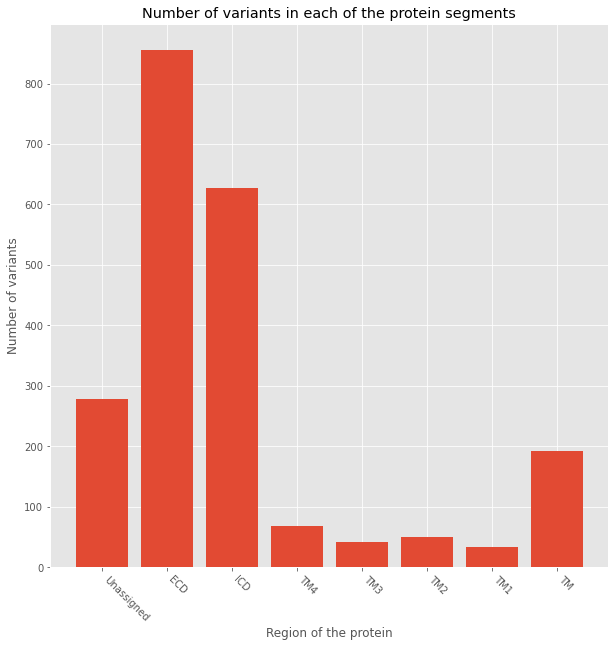

In [672]:
pyplot.bar(region_count["Region"], region_count["Count"])
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Region of the protein")
pyplot.ylabel("Number of variants")
pyplot.title("Number of variants in each of the protein segments")
pyplot.show()

Next we visualize the relative number of variants per segment. For this we divided the total number of variants in each segment with its length. As the last column we also add in a blue color data for the full length of the reference sequence.  

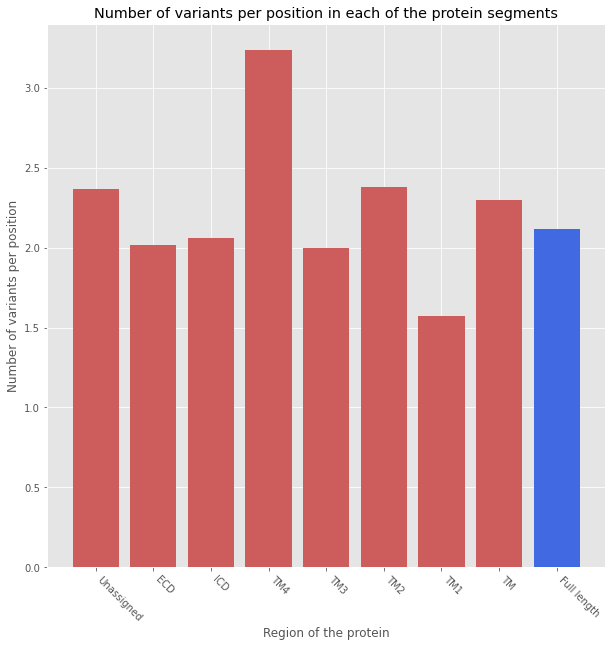

In [673]:
pyplot.bar(region_count["Region"], region_count["Relative"], color="indianred")
pyplot.bar(["Full length"], [region_count["Count"].sum()/region_count["Length"].sum()], color="royalblue")
pyplot.xticks(rotation=-45, horizontalalignment="left")
pyplot.xlabel("Region of the protein")
pyplot.ylabel("Number of variants per position")
pyplot.title("Number of variants per position in each of the protein segments")
pyplot.show()

Next we will count the number of variants on each position in the reference sequence.

In [674]:
x = missense["AA Referenced"][~missense["AA Referenced"].isna()]
x = x[x != -1]
# Spawning every position with a default value (0.0) if it does not exist
x = defaultdict(float, Counter(x))
for i in range(1, len(alignment[0])+1):
    x[i]
x = pandas.DataFrame.from_dict({"AA Referenced":x.keys(), "Count":x.values()})
x

,AA Referenced,Count
0,91,2.0
1,111,4.0
2,128,10.0
3,139,7.0
4,320,4.0
...,...,...
1009,1010,0.0
1010,1011,0.0
1011,1012,0.0
1012,1013,0.0


Asigning regions to the segments.

In [675]:
# Annotating regions
x["Region"] = ""
for element in structural_elements["BS"].unique():
    x["Region"][(x["AA Referenced"] > min(structural_elements["AA Referenced"][structural_elements["BS"] == element])) & (x["AA Referenced"] < max(structural_elements["AA Referenced"][structural_elements["BS"] == element]))] = element
x

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,AA Referenced,Count,Region
0,91,2.0,
1,111,4.0,ECD
2,128,10.0,ECD
3,139,7.0,ECD
4,320,4.0,ECD
...,...,...,...
1009,1010,0.0,
1010,1011,0.0,
1011,1012,0.0,
1012,1013,0.0,


In [676]:
# Checking the number of amino acids present per position in the alignment
positional_count = numpy.array([len(alignment[:, i].replace("-", "")) for i in range(0, len(alignment[0]))])
positional_count

array([1, 1, 1, ..., 1, 1, 1])

The majority of the positions is occupied by a single sequence. We should probably discard those. Note though that they could be just a single position. In that case we will probably want to retain them.

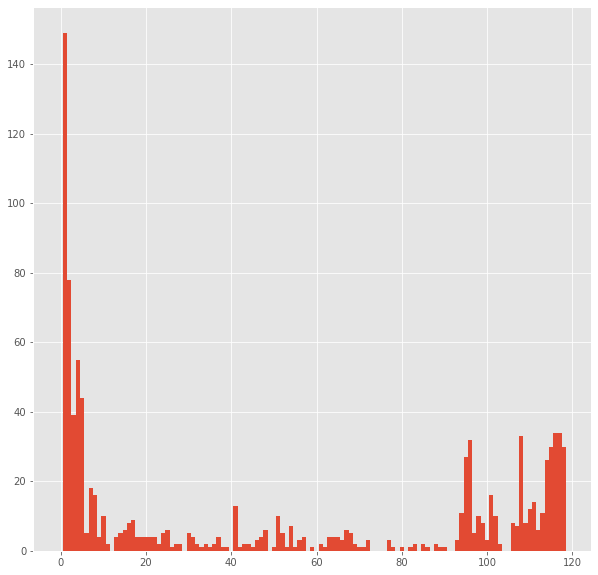

In [677]:
pyplot.hist(positional_count, bins = range(0, max(positional_count)), lw=0, align="left", )
pyplot.show()

First though we want to also check on the single-sequence positions how many mutations map there.

In [678]:
positional_variants = numpy.array([(found_missense["AA Referenced"] == i).sum() for i in range(0, len(alignment[0]))])
print(((positional_variants > 0) & (positional_count == 1)).sum())
print((positional_count == 1).sum())

14
149


So the majority of the single-sequence positions don't have any mutation mapped. Thus, we will be better served if we disregard them. For each position with a single amino acid in it we will discard it if the neighboring positions also have a single amino acid. So we first compute a mask, which we then apply to the whole sequence.

In [679]:
ali_class.filter_sequence()

found_missense["AA Referenced_filtered"] = found_missense.apply(lambda y: ali_class.convert_to_filtered(y["AA Referenced"]), axis=1)
found_missense

C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,level_0,index,Chromosome,Position,rsIDs,Reference,Alternate,Source,Filters - exomes,Filters - genomes,...,Allele Number European (non-Finnish),Homozygote Count European (non-Finnish),Hemizygote Count European (non-Finnish),Gene,Transcript,AA Number,AA Relative,AA Referenced,Region,AA Referenced_filtered
0,26,535,4,47031703.0,rs977009229,A,G,gnomAD Genomes,NaN,PASS,...,68016.0,0.0,0.0,GABRB1,NaN,18,0.037975,91,,80
1,78,595,4,47031919.0,rs148675961,A,G,gnomAD Genomes,NaN,PASS,...,68002.0,0.0,0.0,GABRB1,NaN,29,0.061181,111,ECD,100
2,87,604,4,47031969.0,rs775250287,A,G,gnomAD Genomes,NaN,PASS,...,68006.0,0.0,0.0,GABRB1,NaN,46,0.097046,128,ECD,117
3,91,608,4,47031996.0,rs142160221,G,A,gnomAD Genomes,NaN,PASS,...,67900.0,0.0,0.0,GABRB1,NaN,55,0.116034,139,ECD,128
4,194,724,4,47161424.0,rs200428754,G,A,gnomAD Genomes,NaN,PASS,...,67964.0,0.0,0.0,GABRB1,NaN,139,0.293249,320,ECD,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,26804,28691,4,46123822.0,rs564894450,T,C,gnomAD Genomes,NaN,PASS,...,68004.0,0.0,0.0,GABRG1,NaN,31,0.066667,54,,43
1964,26812,28699,4,46123859.0,rs770228084,T,C,gnomAD Genomes,NaN,PASS,...,68012.0,0.0,0.0,GABRG1,NaN,19,0.040860,42,,31
1965,26813,28700,4,46123866.0,rs148202098,A,T,gnomAD Genomes,NaN,PASS,...,68006.0,0.0,0.0,GABRG1,NaN,16,0.034409,39,,28
1966,26818,28705,4,46123877.0,rs140068403,G,T,gnomAD Genomes,NaN,PASS,...,68012.0,0.0,0.0,GABRG1,NaN,13,0.027957,36,,25


How many missense variants do we loose? Out of 1955 we further loose 15. Not a bad figure. 

In [680]:
sum(found_missense["AA Referenced_filtered"] == -1)

15

In [681]:
found_missense[["Gene", "Allele Count", "Region", "AA Referenced"]][found_missense["AA Referenced_filtered"] == -1]

,Gene,Allele Count,Region,AA Referenced
48,CHRNA1,4.0,ECD,249
49,CHRNA1,5.0,ECD,245
50,CHRNA1,72.0,ECD,245
251,5HT3E,6.0,ECD,214
252,5HT3E,14.0,ECD,221
253,5HT3E,4.0,ECD,223
254,5HT3E,4.0,ECD,229
255,5HT3E,25.0,ECD,231
342,5HT3D,4.0,ECD,364
343,5HT3D,424.0,ECD,364


How many positions in the reference alignment did we discard?

In [682]:
print(sum([y == -1 for y in ali_class.precomputed_filter]))
print(len(ali_class.precomputed_filter))

136
1014


What if we would do the same, but regard isoforms of a individual gene as one?

In [684]:
ali_class.filter_sequence(group_isoforms=True)

found_missense["AA Referenced_filtered_grouped"] = found_missense.apply(lambda y: ali_class.convert_to_filtered(y["AA Referenced"]), axis=1)
print(f"Number of discarded variants: {sum(found_missense['AA Referenced_filtered_grouped'] == -1)}")
found_missense[["Gene", "Allele Count", "Region", "AA Referenced"]][found_missense["AA Referenced_filtered_grouped"] == -1]

Number of discarded variants: 16


C:\ProgramData\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gene,Allele Count,Region,AA Referenced
48,CHRNA1,4.0,ECD,249
49,CHRNA1,5.0,ECD,245
50,CHRNA1,72.0,ECD,245
251,5HT3E,6.0,ECD,214
252,5HT3E,14.0,ECD,221
253,5HT3E,4.0,ECD,223
254,5HT3E,4.0,ECD,229
255,5HT3E,25.0,ECD,231
342,5HT3D,4.0,ECD,364
343,5HT3D,424.0,ECD,364


In [686]:
print(f"Number of discarded positions in the alignment: {sum([y == -1 for y in ali_class.precomputed_filter])}")
print(f"Initial length of the alignment: {len(ali_class.precomputed_filter)}")

Number of discarded positions in the alignment: 163
Initial length of the alignment: 1014


So we ultimately discard more positions if we group the isoforms together, but this only results in a loss of one variant.

Plotting a histogram of variant counts. X axis is thus number of variants on a single position, while y axis represents number of positions with a certain number of variants.

In [ ]:
matplotlib.rcParams["figure.figsize"] = (30, 10)

In [ ]:
pyplot.hist(x["Count"], bins = range(0, int(max(x["Count"]))))
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.title("Distribution of variant counts")
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Number of positions")
pyplot.show()

Next we divide the variant counts based on the structural elements.

In [ ]:
pyplot.hist(x["Count"][x["Region"] == "ECD"], bins = range(0, int(max(x["Count"]))), color="royalblue", lw=0, label="ECD")
pyplot.hist(x["Count"][x["Region"] == "ICD"], bins = range(0, int(max(x["Count"]))), color="green", lw=0, label="ICD")
pyplot.hist(x["Count"][x["Region"].isin(("TM1", "TM2", "TM3", "TM4"))], bins = range(0, int(max(x["Count"]))), color="darkviolet", lw=0, label="TMD")
pyplot.title("Distribution of variant counts in different structural segments")
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Number of positions")
pyplot.legend(prop={"size": 20})
pyplot.show()

We normalize to the length of the segments and produce first an overlaid histogram and then separate histograms for different structural elements.

In [ ]:
pyplot.hist(x["Count"][x["Region"] == "ECD"], bins = range(0, int(max(x["Count"]))), color="royalblue", lw=0, label="ECD", density=True, align="left", alpha=0.5)
pyplot.hist(x["Count"][x["Region"] == "ICD"], bins = range(0, int(max(x["Count"]))), color="goldenrod", lw=0, label="ICD", density=True, align="left", alpha=0.5)
pyplot.hist(x["Count"][x["Region"].isin(("TM1", "TM2", "TM3", "TM4"))], bins = range(0, int(max(x["Count"]))), color="red", lw=0, label="TMD", density=True, align="left", alpha=0.5)
pyplot.title("Relative distribution of variant counts in different structural segments")
pyplot.xticks(range(0, int(max(x["Count"]))))
pyplot.xlabel("Number of mutations on a codon")
pyplot.ylabel("Proportion of positions")
pyplot.legend(prop={"size": 20})
pyplot.show()


Splitting the histograms

In [ ]:
for y in (("ECD",), ("ICD",), ("TM1", "TM2", "TM3", "TM4")):
    pyplot.hist(x["Count"][x["Region"].isin(y)], bins = range(0, int(max(x["Count"]))), color="navy", lw=0, density=True, align="left")
    pyplot.xticks(range(0, int(max(x["Count"]))))
    pyplot.title(f"Relative distribution of variant counts in {y[0].split('1')[0]}")
    pyplot.xlabel(f"Number of mutations on a codon")
    pyplot.ylabel("Proportion of positions")
    pyplot.show()

## Looking at the binding sites

We have the annotation for different binding sites. We first load this data into a data frame and check it. We see that we have each position in the binding sites linked to three different sequences. For our purpose we will use GABRA1 from AlphaFold. This sequence is taken from UniProt and so we are sure we have it in our reference alignment.

In [ ]:
binding_sites = pandas.read_csv("Binding_sites_numbering.csv")
binding_sites

First we need to separate the amino acid abbreviation from the numbering. We store these into separate columns.

In [ ]:
binding_sites["AA"] = binding_sites["GABRA1_Alphafold"].str[0]
binding_sites["AA Number"] = binding_sites["GABRA1_Alphafold"].str[1:]
binding_sites

Next we want to convert the number into the number in the reference sequence. First we couble check if the function accepts our input. Then we perform the search for each row in the table. 

In [ ]:
ali_class.find_reference("GABRA1", binding_sites.iloc[0]["AA"], int(binding_sites.iloc[0]["AA Number"]))

In [ ]:
binding_sites["AA Referenced"] = binding_sites.apply(lambda y: ali_class.find_reference("GABRA1", y["AA"], int(y["AA Number"])), axis=1)
binding_sites

We check next how many amino acids are unassigned. We see there are none.

In [ ]:
sum(binding_sites["AA Referenced"] == -1)

## Checking TMD binding sites

We first check which binding sites we have the annotation for. As we can see this is the case for 7 binding sites.

In [ ]:
binding_sites["BS"].unique()

Of all the binding sites we have the annotation for three TMD sites. We will first put them into a list for easier handling later on.

In [ ]:
bs_interest = ["3 (upperTMD)", "3.5 (upperTMD - IVM)", "4 (interface steroid site)"]


### Upper TMD site - site 3

We first check site 3 (first in the list). We filter the missense mutations we could put on the reference sequence so we retain only the mutations on the positions linked to the binding site.

In [ ]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[0]])]
site_data.head()

Next we use this filtered data to count the number of variants for each gene and each position in the binding site. This way we get a 2D list which we can use to make a heatmap. 

In [ ]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[0]]
data = [[sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)) for aa in aacids] for gene in genes]
print(data)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[0]} binding site",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

We repeat this procedure, but instead of counting the number of variants, we sum up the allele counts. This gives us the information on how much the variants at each position are propagated throughout the population in each gene.

In [ ]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[0]]
data = [[sum(site_data["Allele Count"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)]) for aa in aacids] for gene in genes]
print(data)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[0]} binding site - Sum of allele counts",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

### Upper TMD IVM site - site 3.5

We repeat completely the same analysis for the site 3.5.

In [ ]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[1]])]
site_data.head()

In [ ]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[1]]
data = [[sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)) for aa in aacids] for gene in genes]
print(data)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[1]} binding site",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

In [ ]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[1]]
data = [[sum(site_data["Allele Count"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)]) for aa in aacids] for gene in genes]
print(data)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[1]} binding site - Sum of allele counts",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

### Interface steroid site - site 4

And finally we also perform the analysis on site 4.

In [ ]:
site_data = found_missense[found_missense["AA Referenced"].isin(binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[2]])]
site_data.head()

In [ ]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[2]]
data = [[sum((site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)) for aa in aacids] for gene in genes]
print(data)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[2]} binding site",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

In [ ]:
genes = site_data["Gene"]
genes = genes.sort_values(ascending=False, ignore_index=True)
aacids = binding_sites["AA Referenced"][binding_sites["BS"] == bs_interest[2]]
data = [[sum(site_data["Allele Count"][(site_data["Gene"] == gene) & (site_data["AA Referenced"] == aa)]) for aa in aacids] for gene in genes]
print(data)

In [ ]:
fig = go.Figure(data=go.Heatmap(
    z = data,
    x=[str(int(aa)) for aa in aacids],
    y=genes,
    hoverongaps=False
))
fig.update_layout(
    title=f"{bs_interest[2]} binding site - Sum of allele counts",
    xaxis_title = "Referenced amino acid position",
    yaxis_title = "Gene"
)
fig.show()

# Extra: Checking H267 and E270 from GABRB3
**Note:** The numbering is without the signal peptide; we add 25 AAs because that is the signal peptide length in GABRB3

In [ ]:
aa_referenced = [ali_class.convert_to_reference("GABRB3", "H", 267+25), ali_class.convert_to_reference("GABRB3", "E", 270+25)]
aa_referenced

In [ ]:
subset = missense[missense["AA Referenced"].isin(aa_referenced)]
subset

In [ ]:
(subset["Gene"] + "_" + subset["AA Referenced"].astype(int).astype(str)).values.tolist()

In [ ]:
matplotlib.rcParams["figure.figsize"] = (10, 10)

In [ ]:
pyplot.bar(subset["Gene"] + "_" + subset["AA Referenced"].astype(int).astype(str), subset["Allele Count"]/subset["Allele Number"]*100)
pyplot.xlabel("Gene")
pyplot.ylabel("Allele Frequency [%]")
pyplot.title("Mutated allele frequency on H276 and E270 positions")
pyplot.show()

**NOTE:**
- GABRB3 H267 = 569
- GABRB3 E270 = 572 